Notebook: Estudo da variação da quantidade de ruído

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal.windows import hann
from matplotlib import gridspec
import json

In [2]:
import utils
import functions_for_noise_study as noisestud
import functions_for_param_study as paramstud

Aquisição dos sinais simulados e geração dos espectrogramas:

In [3]:
qntty = 100
test_not_save = True

In [4]:
#Import data obtained on EditedMRS_Reconstruction_Challenge github -- Ground-truths
with h5py.File('../sample_data.h5') as hf:
  print(hf.keys())
  gt_fids = hf["ground_truth_fids"][()][:qntty]
  ppm = hf["ppm"][()][:qntty]
  t = hf["t"][()][:qntty]
  print(gt_fids.shape)
  print(ppm.shape)
  print(t.shape)

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>
(100, 2048, 2)
(100, 2048)
(100, 2048)


In [5]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime
N = gt_fids.shape[1]

#note: if we use np.fft.fftshift(np.fft.ifft()) to get the spectrum, if we use np.flip(np.fft.fftshift(np.fft.fftfreq())) the frequency values
#will start from the most positive to the most negative, as in the ppm axis. Then freq[i] will have its correspondent ppm value in ppm[i]
#and the spectrum in the frequency freq[i] will be obtainted by spectrum[0,i]
#however, this is by using the inverse fourier transform to get the spectrum, and we want to use the Fourier transform
#for this we do np.fft.fftshift(np.fft.fft()) to get the spectrum, but still we flip the frequency axis as np.flip(np.fft.fftshift(np.fft.fftfreq())),
#so the freq[i] will have its correspondent ppm value in ppm[i], but the spectrum at a given frequency f will occur at 
#spectrum[0,np.abs(np.flip(freq)-f).argmin()], i.e. the frequency axis is flipped with respect to the spectrum, and the ppm axis as well
#this also happens for the spectrogram...
#gts
spectra_gt_fids = np.fft.fftshift(np.fft.fft(gt_fids,n=N,axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(N, d = dwelltime)))
#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
#not really necessary to flip to find a and b since freq and ppm agree, but we use it to enphasize the flip
#and also so np.flip(ppm)[0,idx_max] = 4.7 ppm, np.flip(ppm)[0,idx_min] = 2 ppm
#and np.flip(freq)[idx_max] = 216 Hz, and np.flip(freq)[idx_min] = -127 Hz, which agree with visual observation
a = (np.flip(ppm)[0,idx_max] - np.flip(ppm)[0,idx_min])/(np.flip(freq)[idx_max]-np.flip(freq)[idx_min])
b = np.flip(ppm)[0,idx_max] - a*np.flip(freq)[idx_max]
#ppm_aux = b + freq*a

spectrum_gt = np.empty(spectra_gt_diff.shape,dtype=spectra_gt_diff.dtype)
for j in range(spectra_gt_diff.shape[0]):
    spectrum_gt[j,:] = utils.normalize_complex_vector_abs(complex_array=spectra_gt_diff[j,:])

In [6]:
#cria fids com ruido
corrupted_fids = {}
std_basis = [1,2,3,4,5,6,7,8,9,10,12,15,17,19]
var_basis = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.5,1.5,1.5,1.5]
for i in range(len(std_basis)):
    corrupted_fids["noise_"+str(std_basis[i])] = utils.create_corrupted_fids(gt=gt_fids,t=t,std_base=std_basis[i],std_var=var_basis[i],ntransients=160)

In [7]:
mfft_ = 600
window_ = hann(mfft_,sym=True)
hop_ = 12
norm_ = 'abs'

In [8]:
spgram_gt, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=gt_fids[:,:,1]-gt_fids[:,:,0],bandwidth=bandwidth,window=window_,mfft=mfft_,hop=hop_,norm=norm_,correct_time=True,a=a,b=b)

In [9]:
spgram_ns = {}
for i in range(len(std_basis)):
    spgram, freq_spect, ppm_spect, t_spect = utils.get_normalized_spectrogram(fids=np.mean(corrupted_fids["noise_"+str(std_basis[i])][:,:,1,:]-corrupted_fids["noise_"+str(std_basis[i])][:,:,0,:],axis=2),bandwidth=bandwidth,window=window_,mfft=mfft_,hop=hop_,norm=norm_,correct_time=True,a=a,b=b)
    spgram_ns['noise_'+str(std_basis[i])] = [spgram, freq_spect, ppm_spect, t_spect]

In [10]:
spectrum_ns = {}
for i in range(len(std_basis)):
    aux_spectrum = np.fft.fftshift(np.fft.fft(np.mean(corrupted_fids["noise_"+str(std_basis[i])][:,:,1,:]-corrupted_fids["noise_"+str(std_basis[i])][:,:,0,:],axis=2),n=N,axis = 1), axes = 1)
    norm_spectrum = np.empty(aux_spectrum.shape,dtype=aux_spectrum.dtype)
    for j in range(aux_spectrum.shape[0]):
        norm_spectrum[j,:] = utils.normalize_complex_vector_abs(complex_array=aux_spectrum[j,:])
    spectrum_ns['noise_'+str(std_basis[i])] = norm_spectrum

Visualização:

Nota-se um aumento na intensidade dos padrões de fundo, visíveis com o contraste utilizado a partir de ruído com nível 4. Visualmente, não se nota diferença na região de picos mais intensos.

(0.0, 1.0, 0.0, 1.0)

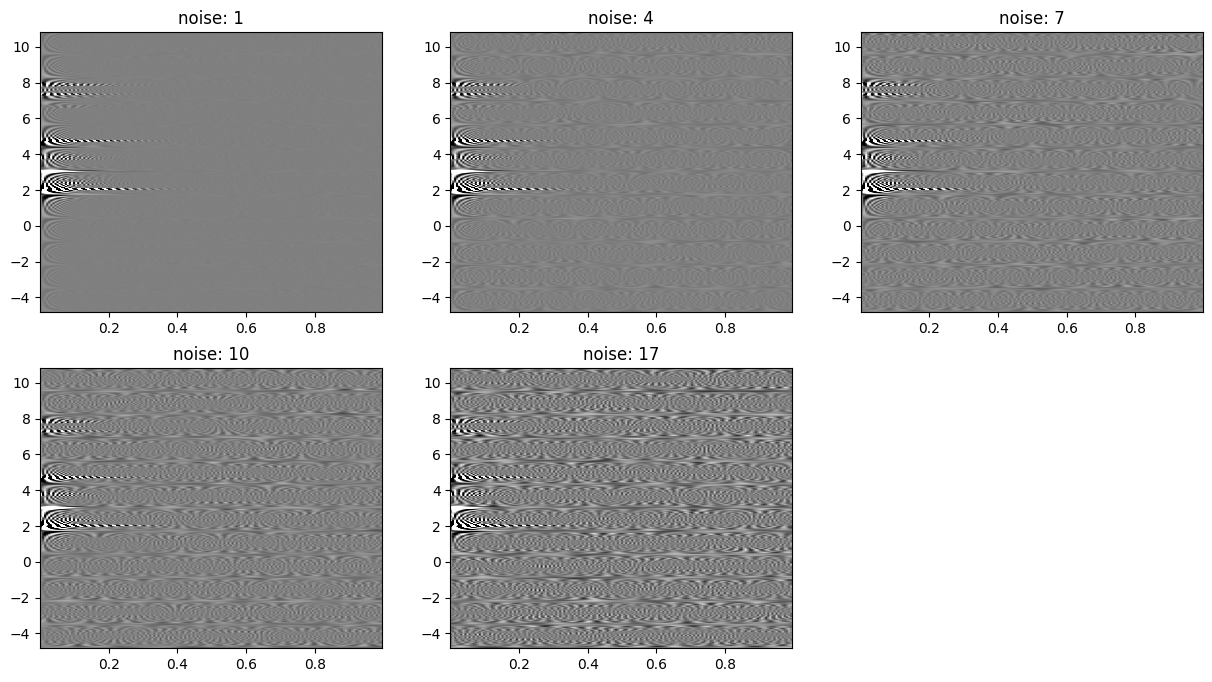

In [11]:
plot_idx = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for k in range(len(plot_idx)):
    ax.flat[k].imshow(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,:,:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (spgram_ns["noise_"+str(std_basis[plot_idx[k]])][-1][0],spgram_ns["noise_"+str(std_basis[plot_idx[k]])][-1][-1],
                    spgram_ns["noise_"+str(std_basis[plot_idx[k]])][2][-1],spgram_ns["noise_"+str(std_basis[plot_idx[k]])][2][0]))
    ax.flat[k].set_title('noise: '+str(std_basis[plot_idx[k]]))

ax.flat[-1].axis('off')

Algumas colunas e linhas de interesse na análise dos espectrogramas:

In [12]:
list_of_t_spects = []
list_of_ppm_spects = []
for i in range(len(std_basis)):
    list_of_t_spects.append(spgram_ns['noise_'+str(std_basis[i])][-1])
    list_of_ppm_spects.append(spgram_ns['noise_'+str(std_basis[i])][2])
idx_time_0d05 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.05)
idx_time_0d4 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.4)
idx_time_0d6 = utils.give_idx_time_point_for_different_time_arrays(list_time_arrays=list_of_t_spects,time_point=0.6)
idx_freq_0ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=0)
idx_freq_1ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=1)
idx_freq_4ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=4)
idx_freq_8ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8)
idx_freq_8d5ppm = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=8.5)
idx_freq_NAA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=2.02)
idx_freq_GABA = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.00)
idx_freq_Glx = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_of_ppm_spects,ppm_point=3.75)

Projeção no eixo da frequência:

A projeção do espectrograma no eixo da frequência dá origem a um sinal unidimensional muito similar ao espectro de GABA. Desse modo, pode-se estimar o ruído do espectro e do espectrograma e comparar os resultados.

(4.0, 1.0)

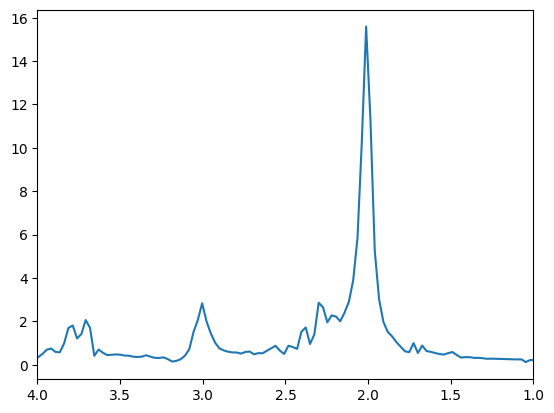

In [13]:
k=0
aux = np.sum(np.abs(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0])),axis=2)
plt.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
plt.xlim(4,1)

Medição do nível de ruído do espectrograma:

Para a medição do nível de ruído define-se as seguintes regiões:
-  Para projeção com valor absoluto e para o espectro de GABA:
    - Regiões: 9.5 - 10.5 ppm, 8.5 - 9.5 ppm, -2 a 0 ppm e -4 a -2 ppm.
- Para projeção com valor real:
    - Regiões: 8.5 - 9.3 ppm, -1.8 a -1.3 ppm e -3.3 a -2.5 ppm
    
A medição do nível de ruído é feita através de um fitting de um polinômio de segundo grau, o qual é subtraído dos dados para então estimar-se o nível de ruído através do desvio padrão desse sinal.



In [14]:
list_ppm_regions_abs = [[9.5,10.5],[8.5,9.5],[-2,0],[-4,-2]]
list_ppm_regions_real = [[8.5,9.3],[-1.8,-1.3],[-3.3,-2.5]]
list_projections_abs = []
list_projections_real = []
list_ppm_array = []
for i in range(len(std_basis)):
    list_projections_abs.append(np.sum(np.abs(np.real(spgram_ns["noise_"+str(std_basis[i])][0])),axis=2))
    list_projections_real.append(np.sum(np.real(spgram_ns["noise_"+str(std_basis[i])][0]),axis=2))
    list_ppm_array.append(spgram_ns["noise_"+str(std_basis[i])][2])
std_estimate_abs = noisestud.spect_noise_estimation(list_spects=list_projections_abs,list_ppm_arrays=list_ppm_array,list_ppm_regions=list_ppm_regions_abs,part='real',degree=2)
std_estimate_real = noisestud.spect_noise_estimation(list_spects=list_projections_real,list_ppm_arrays=list_ppm_array,list_ppm_regions=list_ppm_regions_real,part='real',degree=2)

E, para comparação, do espectro:

In [15]:
list_ppm_regions_spectrum = [[9.5,10.5],[8.5,9.5],[-2,0],[-4,-2]]
list_spectrum = []
list_ppm_array_spectrum = []
for i in range(len(std_basis)):
    list_spectrum.append(np.real(spectrum_ns["noise_"+str(std_basis[i])]))
    list_ppm_array_spectrum.append(ppm[0,:])
std_estimate_spectrum = noisestud.spect_noise_estimation(list_spects=list_spectrum,list_ppm_arrays=list_ppm_array_spectrum,list_ppm_regions=list_ppm_regions_spectrum,part='real',degree=2)

Visualização dos fits no espectrograma:

Da observação da qualidade dos fits, nota-se que o fitting polinomial parece descrever bem a tendência das regiões da projeção real do espectrograma e das regiões do espectro, porém, o fitting nas regiões da projeção do valor absoluto do espectrograma parece superestimar os valores da região.

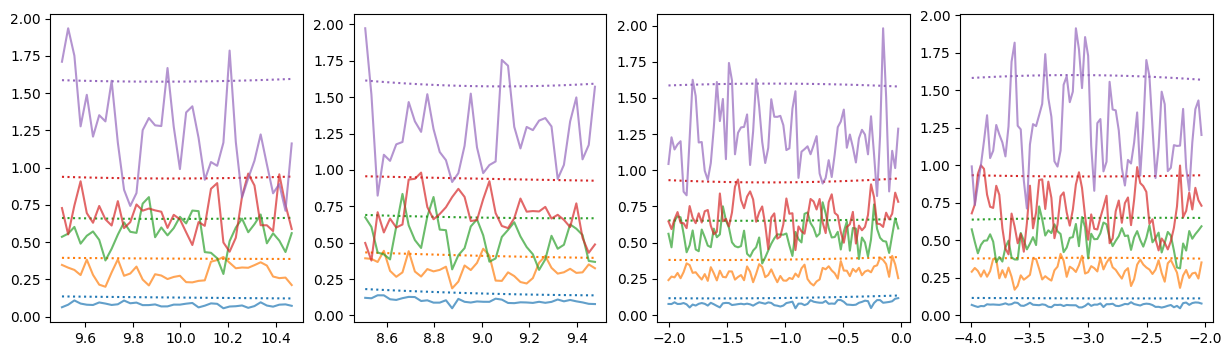

In [16]:
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_idx = np.arange(0,len(std_basis),3)
plot_abs = True
fig,ax = plt.subplots(1,len(list_ppm_regions_abs),figsize=(15,4))
for k in range(len(plot_idx)):
    for j in range(len(list_ppm_regions_abs)):
        idx_str = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=list_ppm_regions_abs[j][0])
        idx_end = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=list_ppm_regions_abs[j][1])
        if plot_abs == True:
            aux = np.sum(np.abs(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,idx_str:idx_end,:])),axis=1)
        else:
            aux = np.sum(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,idx_str:idx_end,:]),axis=1)
        aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2])[idx_str:idx_end]
        ax.flat[j].plot(aux_xaxis,aux, label = "noise: "+str(std_basis[plot_idx[k]]),color=colors[k],alpha=0.7)
        ax.flat[j].plot(aux_xaxis,(std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['avg_coefs'][plot_idx[k]][0]+
                                    std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['avg_coefs'][plot_idx[k]][1]*aux_xaxis+
                                    std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['avg_coefs'][plot_idx[k]][2]*(aux_xaxis**2)),color=colors[k],linestyle='dotted')

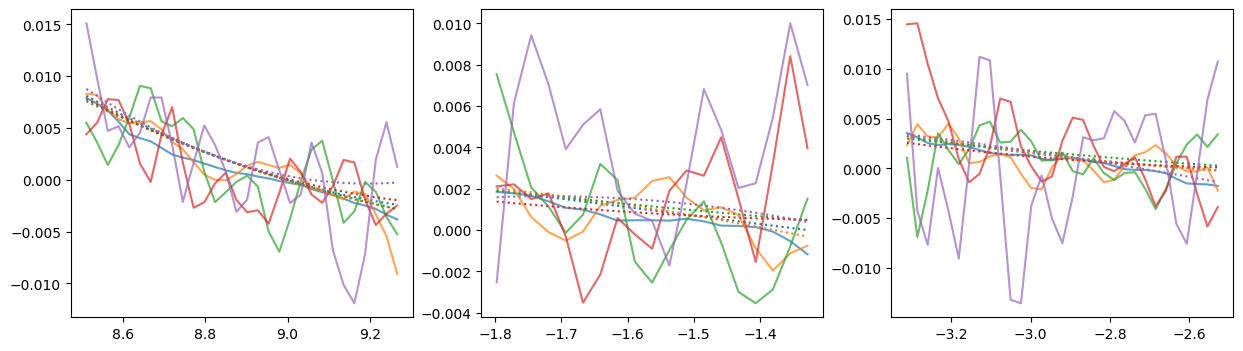

In [17]:
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_idx = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(1,len(list_ppm_regions_real),figsize=(15,4))
for k in range(len(plot_idx)):
    for j in range(len(list_ppm_regions_real)):
        idx_str = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=list_ppm_regions_real[j][0])
        idx_end = utils.give_idx_ppm_point(ppm_array=spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2],ppm_point=list_ppm_regions_real[j][1])
        aux = np.sum(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0][0,idx_str:idx_end,:]),axis=1)
        aux_xaxis = np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2])[idx_str:idx_end]
        ax.flat[j].plot(aux_xaxis,aux, label = "noise: "+str(std_basis[plot_idx[k]]),color=colors[k],alpha=0.7)
        ax.flat[j].plot(aux_xaxis,(std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['avg_coefs'][plot_idx[k]][0]+
                                    std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['avg_coefs'][plot_idx[k]][1]*aux_xaxis+
                                    std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['avg_coefs'][plot_idx[k]][2]*(aux_xaxis**2)),color=colors[k],linestyle='dotted')

Visualização dos fits no espectro:

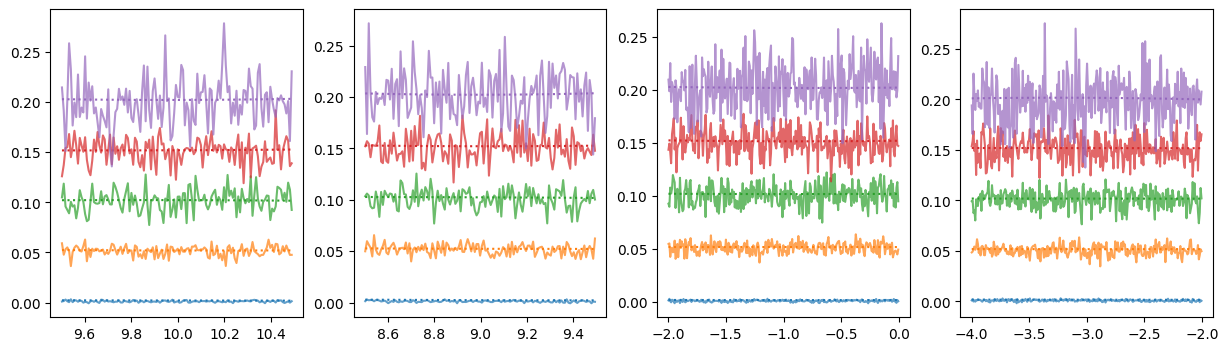

In [18]:
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_idx = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(1,len(list_ppm_regions_spectrum),figsize=(15,4))
for k in range(len(plot_idx)):
    for j in range(len(list_ppm_regions_spectrum)):
        idx_str = utils.give_idx_ppm_point(ppm_array=ppm[0,:],ppm_point=list_ppm_regions_spectrum[j][0])
        idx_end = utils.give_idx_ppm_point(ppm_array=ppm[0,:],ppm_point=list_ppm_regions_spectrum[j][1])
        aux = np.real(spectrum_ns["noise_"+str(std_basis[plot_idx[k]])][0,idx_str:idx_end])
        aux_xaxis = np.flip(ppm)[0,idx_str:idx_end]
        ax.flat[j].plot(aux_xaxis,aux+0.05*k, label = "noise: "+str(std_basis[plot_idx[k]]),color=colors[k],alpha=0.7)
        ax.flat[j].plot(aux_xaxis,(std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['avg_coefs'][plot_idx[k]][0]+
                                    std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['avg_coefs'][plot_idx[k]][1]*aux_xaxis+
                                    std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['avg_coefs'][plot_idx[k]][2]*(aux_xaxis**2))+0.05*k,color=colors[k],linestyle='dotted')

Da análise do nível de ruído estimado em função do nível de ruído adicionado aos transientes individuais:

Para o espectro, bem como para as duas projeções consideradas, o nível de ruído estimado aumenta linearmente com o nível de ruído adicionado. O nível de ruído estimado é consideravelmente inferior ao nível de ruído adicionado, devido a técnica de 'averaging'.

Os níveis de ruído estimados em diferentes regiões coincidem no geral, havendo maior divergência entre a região -1,8:-1,3 ppm e as demais na projeção dos valores reais. 

O ruído estimado na projeção de valores absolutos é aproximadamente 10 vezes maior que o ruído estimado no espectro,  que, por sua vez, é aproximadamente 4 vezes o ruído estimado na projeção real. A projeção do valor absoluto soma a contribuição de todo o ruído ao longo de todas as colunas da imagem, levando a uma estimação superior. Já o ruído estimado na projeção real é inferior, pois variações positivas e negativas se cancelam. Tal resultado sugere que o uso da projeção real para quantificação do GABA e análise do sinal pode ser interessante.

Text(0, 0.5, 'Noise measured: Avg. Spectrum')

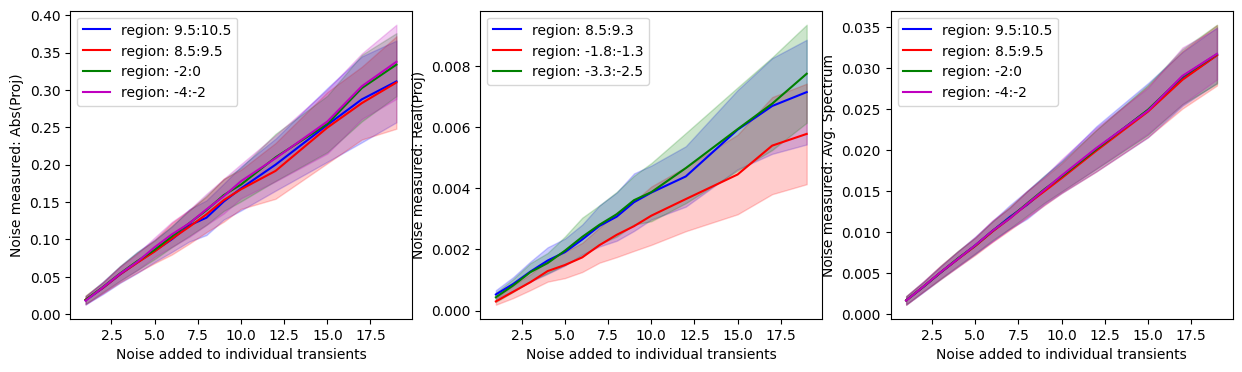

In [19]:
colors = ['b','r','g','m']
fig,ax = plt.subplots(1,3,figsize=(15,4))
for j in range(len(list_ppm_regions_abs)):
    aux = np.array(std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['mean'])
    aux_std = np.array(std_estimate_abs[str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1])]['std'])
    ax[0].plot(std_basis,aux,label='region: '+str(list_ppm_regions_abs[j][0])+':'+str(list_ppm_regions_abs[j][1]),color=colors[j])
    ax[0].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[0].legend(loc='upper left')
ax[0].set_xlabel('Noise added to individual transients')
ax[0].set_ylabel('Noise measured: Abs(Proj)')
for j in range(len(list_ppm_regions_real)):
    aux = np.array(std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['mean'])
    aux_std = np.array(std_estimate_real[str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1])]['std'])
    ax[1].plot(std_basis,aux,label='region: '+str(list_ppm_regions_real[j][0])+':'+str(list_ppm_regions_real[j][1]),color=colors[j])
    ax[1].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[1].legend(loc='upper left')
ax[1].set_xlabel('Noise added to individual transients')
ax[1].set_ylabel('Noise measured: Real(Proj)')

for j in range(len(list_ppm_regions_spectrum)):
    aux = np.array(std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['mean'])
    aux_std = np.array(std_estimate_spectrum[str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1])]['std'])
    ax[2].plot(std_basis,aux,label='region: '+str(list_ppm_regions_spectrum[j][0])+':'+str(list_ppm_regions_spectrum[j][1]),color=colors[j])
    ax[2].fill_between(std_basis, aux - aux_std, 
                        aux + aux_std, alpha=0.2, color = colors[j])
ax[2].legend(loc='upper left')
ax[2].set_xlabel('Noise added to individual transients')
ax[2].set_ylabel('Noise measured: Avg. Spectrum')

Medição da FWHM das projeções para os picos de NAA, GABA e Glx:

Visualmente, observa-se:
- Para projeção abs(real(STFT)): picos parecem afinar ligeiramente com o aumento do ruído, em especial os picos de Glx e NAA.
- Para projeção real(STFT): não há diferença na largura dos picos. 
- Para o espectro de GABA:  não há diferença na largura dos picos. 

Das métricas:
- Para projeção abs(real(STFT)): devido a amplitude dos picos, nota-se uma elevada incerteza na medição da FWHM para os picos de GABA e Glx. O aumento de FWHM para o pico de Glx com o ruído provavelmente está ligado a uma dificuldade do algoritmo de identificar o pico na presença de ruído elevado, visto que, visualmente, tal impressão não se verifica. Através da FWHM nota-se um afinamento dos picos de GABA e NAA com o ruído, concordando com as observações visuais.
- Para projeção real(STFT): 


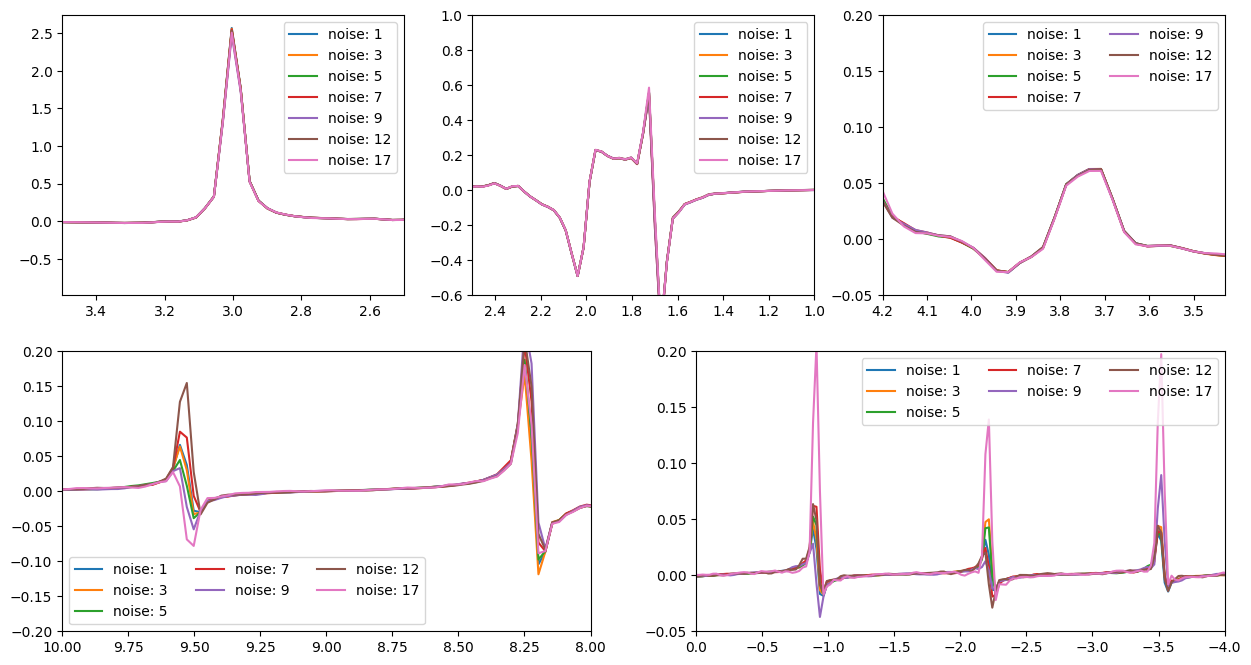

In [45]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((2, 3), (0, 0))  
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2)) 

ax4 = plt.subplot2grid((2, 2), (1, 0))  
ax5 = plt.subplot2grid((2, 2), (1, 1))

plot_idx = np.arange(0,len(std_basis),2)
plot_abs = False
plot_gt = False
for k in range(len(plot_idx)):
    if plot_abs == True:
        #correçaõ do nível basal
        aux_abs = np.sum(np.abs(np.real(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][0])), axis = 2)
        aux_abs_mean = np.mean(aux_abs)
        aux = aux_abs-aux_abs_mean
    else:
        aux = np.sum(np.real(spgram_ns["noise_"+str(std_basis[plot_idx[k]])][0]),axis=2)
    ax1.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
    ax2.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
    ax3.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
    ax4.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
    ax5.plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_idx[k]])][2]),np.mean(aux,axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))

ax1.set_xlim(3.5,2.5) 
ax2.set_xlim(2.5,1)  
ax3.set_xlim(4.2,3.43)
ax4.set_xlim(10,8)
ax5.set_xlim(0,-4)
if plot_abs == True:
    ax1.set_ylim(-0.5,2.5)
    ax3.set_ylim(-0.5,2.5)
    ax4.set_ylim(-0.5,0.2)
    ax5.set_ylim(-0.5,0.2)
else:
    ax2.set_ylim(-0.6,1)
    ax3.set_ylim(-0.05,0.2)
    ax4.set_ylim(-0.2,0.2)
    ax5.set_ylim(-0.05,0.2)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right',ncols=2)

if plot_gt == True:
    if plot_abs == True:
        aux = np.mean(np.sum(np.abs(np.real(spgram_gt)),axis=2),axis=0)-0.4
    else:
        aux = np.mean(np.sum(np.real(spgram_gt),axis=2),axis=0)
    ax1.plot(np.flip(spgram_ns['noise_'+str(std_basis[0])][2]),aux, label = "gt")
    ax2.plot(np.flip(spgram_ns['noise_'+str(std_basis[0])][2]),aux, label = "gt")
    ax3.plot(np.flip(spgram_ns['noise_'+str(std_basis[0])][2]),aux, label = "gt")
    ax4.plot(np.flip(spgram_ns['noise_'+str(std_basis[0])][2]),aux, label = "gt")
    ax5.plot(np.flip(spgram_ns['noise_'+str(std_basis[0])][2]),aux, label = "gt")

if plot_abs == True:
    ax4.legend(loc='upper right',ncols=3)
else:
    ax4.legend(loc='lower left',ncols=3)
ax5.legend(loc='upper right',ncols=3)

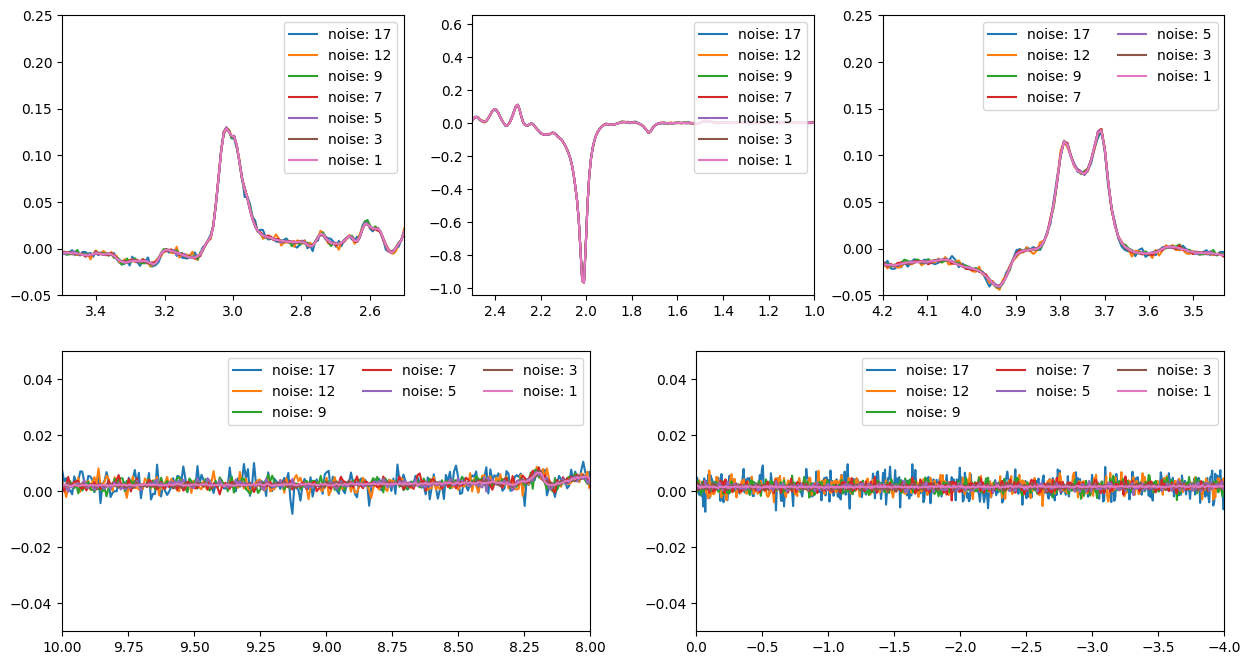

In [46]:
fig = plt.figure(figsize=(15,8))
ax1 = plt.subplot2grid((2, 3), (0, 0))  
ax2 = plt.subplot2grid((2, 3), (0, 1))
ax3 = plt.subplot2grid((2, 3), (0, 2)) 

ax4 = plt.subplot2grid((2, 2), (1, 0))  
ax5 = plt.subplot2grid((2, 2), (1, 1))

plot_gt = False
plot_idx = np.arange(0,len(std_basis),2)
for k in reversed(range(len(plot_idx))):
        ax1.plot(np.flip(ppm[0,:]),np.mean(np.real(spectrum_ns['noise_'+str(std_basis[plot_idx[k]])]),axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
        ax2.plot(np.flip(ppm[0,:]),np.mean(np.real(spectrum_ns['noise_'+str(std_basis[plot_idx[k]])]),axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
        ax3.plot(np.flip(ppm[0,:]),np.mean(np.real(spectrum_ns['noise_'+str(std_basis[plot_idx[k]])]),axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
        ax4.plot(np.flip(ppm[0,:]),np.mean(np.real(spectrum_ns['noise_'+str(std_basis[plot_idx[k]])]),axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))
        ax5.plot(np.flip(ppm[0,:]),np.mean(np.real(spectrum_ns['noise_'+str(std_basis[plot_idx[k]])]),axis=0), label = "noise: "+str(std_basis[plot_idx[k]]))

if plot_gt == True:
    aux = np.mean(np.real(spectrum_gt),axis=0)
    ax1.plot(np.flip(ppm[0,:]),aux, label = "gt")
    ax2.plot(np.flip(ppm[0,:]),aux, label = "gt")
    ax3.plot(np.flip(ppm[0,:]),aux, label = "gt")
    ax4.plot(np.flip(ppm[0,:]),aux, label = "gt")
    ax5.plot(np.flip(ppm[0,:]),aux, label = "gt")

ax1.set_xlim(3.5,2.5) 
ax2.set_xlim(2.5,1)  
ax3.set_xlim(4.2,3.43)
ax4.set_xlim(10,8)
ax5.set_xlim(0,-4)
ax1.set_ylim(-0.05,0.25)
ax3.set_ylim(-0.05,0.25)
ax4.set_ylim(-0.05,0.05)
ax5.set_ylim(-0.05,0.05)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right',ncols=2)
ax4.legend(loc='upper right',ncols=3)
ax5.legend(loc='upper right',ncols=3)

In [20]:
list_projections_abs = []
list_projections_real = []
fwhm_ns = {}
idx_fwhm = {}
fwhm_ns_real = {}
idx_fwhm_real = {}
for i in range(len(std_basis)):
    aux_abs = np.sum(np.abs(np.real(spgram_ns['noise_'+str(std_basis[i])][0])), axis = 2)
    aux_abs_mean = np.mean(aux_abs,axis=1,keepdims=True)
    list_projections_abs.append(aux_abs-aux_abs_mean)
    list_projections_real.append(np.sum(np.real(spgram_ns['noise_'+str(std_basis[i])][0]), axis = 2))
    idx_fwhm['noise_'+str(std_basis[i])] = {}
    idx_fwhm_real['noise_'+str(std_basis[i])] = {}

fwhm_ns['NAA'], aux_idx_NAA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
fwhm_ns['GABA'], aux_idx_GABA_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_ns['Glx'], aux_idx_Glx_abs = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_abs,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

fwhm_ns_real['NAA'], aux_idx_NAA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_NAA,list_ppm=list_of_ppm_spects,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_ns_real['GABA'], aux_idx_GABA_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_GABA,list_ppm=list_of_ppm_spects,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_ns_real['Glx'], aux_idx_Glx_real = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_projections_real,list_peak_idx=idx_freq_Glx,list_ppm=list_of_ppm_spects,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(std_basis)):
    idx_fwhm['noise_'+str(std_basis[i])]['NAA'] = aux_idx_NAA_abs[i]
    idx_fwhm['noise_'+str(std_basis[i])]['GABA'] = aux_idx_GABA_abs[i]
    idx_fwhm['noise_'+str(std_basis[i])]['Glx'] = aux_idx_Glx_abs[i]
    idx_fwhm_real['noise_'+str(std_basis[i])]['NAA'] = aux_idx_NAA_real[i]
    idx_fwhm_real['noise_'+str(std_basis[i])]['GABA'] = aux_idx_GABA_real[i]
    idx_fwhm_real['noise_'+str(std_basis[i])]['Glx'] = aux_idx_Glx_real[i]

In [21]:
#for reference:
fwhm_abs_spgram_gt={}
fwhm_real_spgram_gt={}
fwhm_abs_spgram_gt['NAA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.abs(np.real(spgram_gt)),axis=2)],list_peak_idx=[idx_freq_NAA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='positive')
fwhm_abs_spgram_gt['GABA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.abs(np.real(spgram_gt)),axis=2)],list_peak_idx=[idx_freq_GABA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_abs_spgram_gt['Glx'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.abs(np.real(spgram_gt)),axis=2)],list_peak_idx=[idx_freq_Glx[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')
fwhm_real_spgram_gt['NAA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.real(spgram_gt),axis=2)],list_peak_idx=[idx_freq_NAA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_real_spgram_gt['GABA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.real(spgram_gt),axis=2)],list_peak_idx=[idx_freq_GABA[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_real_spgram_gt['Glx'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[np.sum(np.real(spgram_gt),axis=2)],list_peak_idx=[idx_freq_Glx[0]],list_ppm=[list_of_ppm_spects[0]],peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

Medição FWHM dos espectros:

In [22]:
list_spectrum = []
list_ppm_array_spectrum = []
fwhm_spectrum = {}
idx_fwhm_spectrum = {}
for i in range(len(std_basis)):
    list_spectrum.append(np.real(spectrum_ns["noise_"+str(std_basis[i])]))
    list_ppm_array_spectrum.append(ppm[0,:])
    idx_fwhm_spectrum['noise_'+str(std_basis[i])] = {}

idx_freq_NAA_spectrum = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_ppm_array_spectrum,ppm_point=2.02)
idx_freq_GABA_spectrum = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_ppm_array_spectrum,ppm_point=3.00)
idx_freq_Glx_spectrum = utils.give_idx_ppm_point_for_different_ppm_arrays(list_ppm_arrays=list_ppm_array_spectrum,ppm_point=3.75)

fwhm_spectrum['NAA'], aux_idx_NAA = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_spectrum,list_peak_idx=idx_freq_NAA_spectrum,list_ppm=list_ppm_array_spectrum,peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_spectrum['GABA'], aux_idx_GABA = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_spectrum,list_peak_idx=idx_freq_GABA_spectrum,list_ppm=list_ppm_array_spectrum,peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_spectrum['Glx'], aux_idx_Glx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=list_spectrum,list_peak_idx=idx_freq_Glx_spectrum,list_ppm=list_ppm_array_spectrum,peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

for i in range(len(std_basis)):
    idx_fwhm_spectrum['noise_'+str(std_basis[i])]['NAA'] = aux_idx_NAA[i]
    idx_fwhm_spectrum['noise_'+str(std_basis[i])]['GABA'] = aux_idx_GABA[i]
    idx_fwhm_spectrum['noise_'+str(std_basis[i])]['Glx'] = aux_idx_Glx[i]

In [23]:
#for reference:
fwhm_spectrum_gt={}
fwhm_spectrum_gt['NAA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[spectra_gt_diff],list_peak_idx=[idx_freq_NAA_spectrum[0]],list_ppm=[list_ppm_array_spectrum[0]],peak_ppm_plus=2.50,peak_ppm_minus=1.50,preference='negative')
fwhm_spectrum_gt['GABA'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[spectra_gt_diff],list_peak_idx=[idx_freq_GABA_spectrum[0]],list_ppm=[list_ppm_array_spectrum[0]],peak_ppm_plus=3.50,peak_ppm_minus=2.50,preference='positive')
fwhm_spectrum_gt['Glx'], aux_idx = utils.get_fwhm_in_ppm_for_different_signals(list_signals=[spectra_gt_diff],list_peak_idx=[idx_freq_Glx_spectrum[0]],list_ppm=[list_ppm_array_spectrum[0]],peak_ppm_plus=4.00,peak_ppm_minus=3.50,preference='positive')

Visualização da FWHM para abs(Proj):

(0.0, 1.0, 0.0, 1.0)

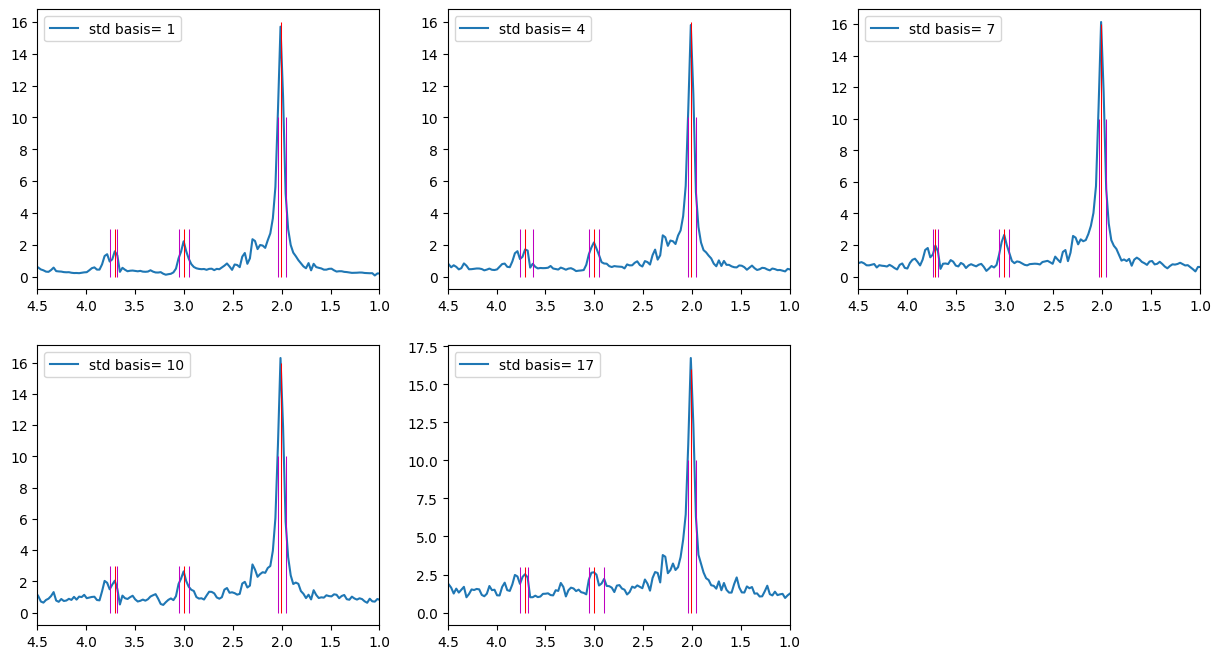

In [24]:
plot_id = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(5):
    ax.flat[i].plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2]),(np.sum(np.abs(np.real(spgram_ns['noise_'+str(std_basis[plot_id[i]])][0][0,:,:])),axis=1)),label='std basis= '+str(std_basis[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,2])],0,16,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,0])],0,10,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,1])],0,10,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,2])],0,3,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,0])],0,3,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,1])],0,3,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,2])],0,3,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,0])],0,3,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,1])],0,3,color='m',linewidth=0.75)
    ax.flat[i].legend(loc='upper left')
ax.flat[-1].axis('off')

Visualização FWHM para real(Proj):

(0.0, 1.0, 0.0, 1.0)

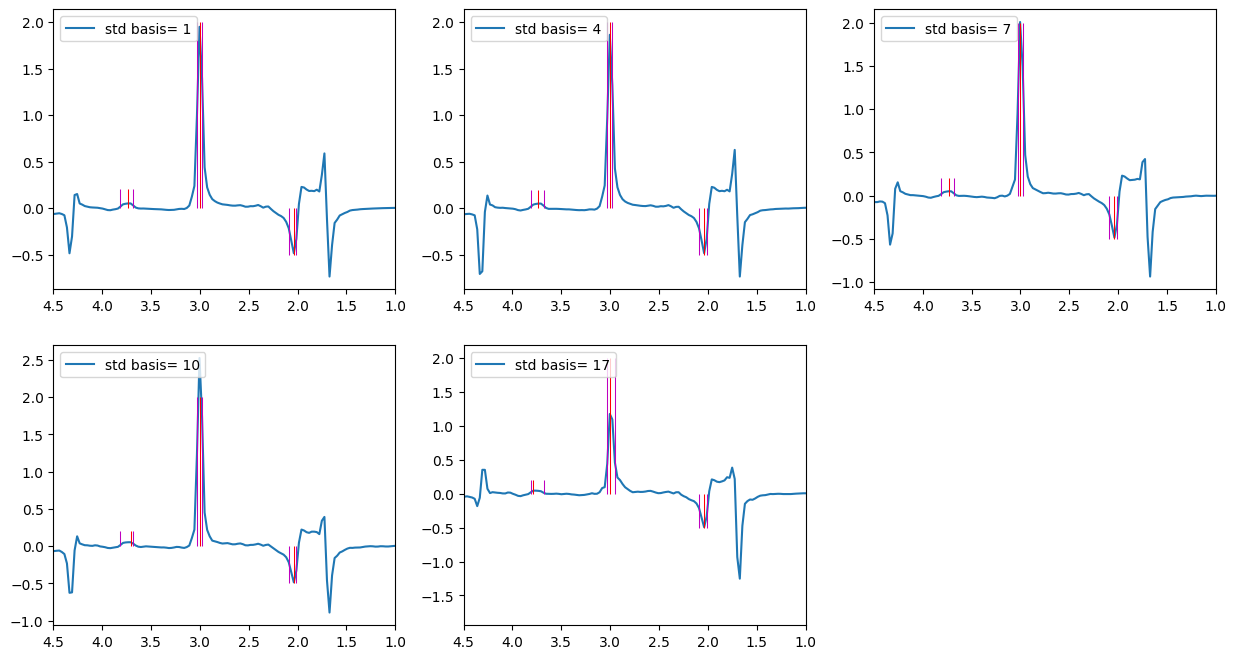

In [50]:
plot_id = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(5):
    ax.flat[i].plot(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2]),(np.sum(np.real(spgram_ns['noise_'+str(std_basis[plot_id[i]])][0][0,:,:]),axis=1)),label='std basis= '+str(std_basis[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,2])],-0.5,0,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,0])],-0.5,0,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,1])],-0.5,0,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,2])],0,2,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,0])],0,2,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,1])],0,2,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,2])],0,0.2,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,0])],0,0.2,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,1])],0,0.2,color='m',linewidth=0.75)
    ax.flat[i].legend(loc='upper left')
ax.flat[-1].axis('off')

Visualização FWHM para o espectro:

(0.0, 1.0, 0.0, 1.0)

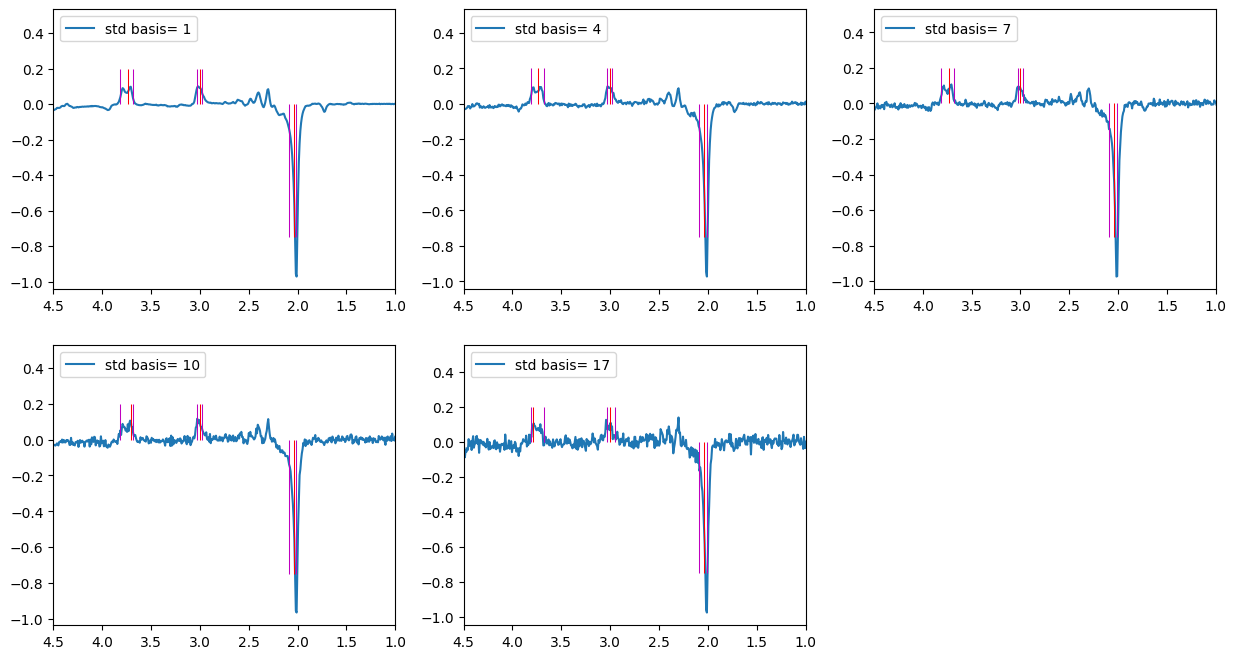

In [26]:
plot_id = np.arange(0,len(std_basis),3)
fig,ax = plt.subplots(2,3,figsize=(15,8))
for i in range(5):
    ax.flat[i].plot(np.flip(ppm[0,:]),np.real(spectrum_ns['noise_'+str(std_basis[plot_id[i]])][0,:]),label='std basis= '+str(std_basis[plot_id[i]]))
    ax.flat[i].set_xlim(4.5,1)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,2])],-0.75,0,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,0])],-0.75,0,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['NAA'][0,1])],-0.75,0,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,2])],0,0.2,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,0])],0,0.2,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['GABA'][0,1])],0,0.2,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,2])],0,0.2,color='r',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,0])],0,0.2,color='m',linewidth=0.75)
    ax.flat[i].vlines(np.flip(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2])[int(idx_fwhm_real['noise_'+str(std_basis[plot_id[i]])]['Glx'][0,1])],0,0.2,color='m',linewidth=0.75)
    ax.flat[i].legend(loc='upper left')
ax.flat[-1].axis('off')

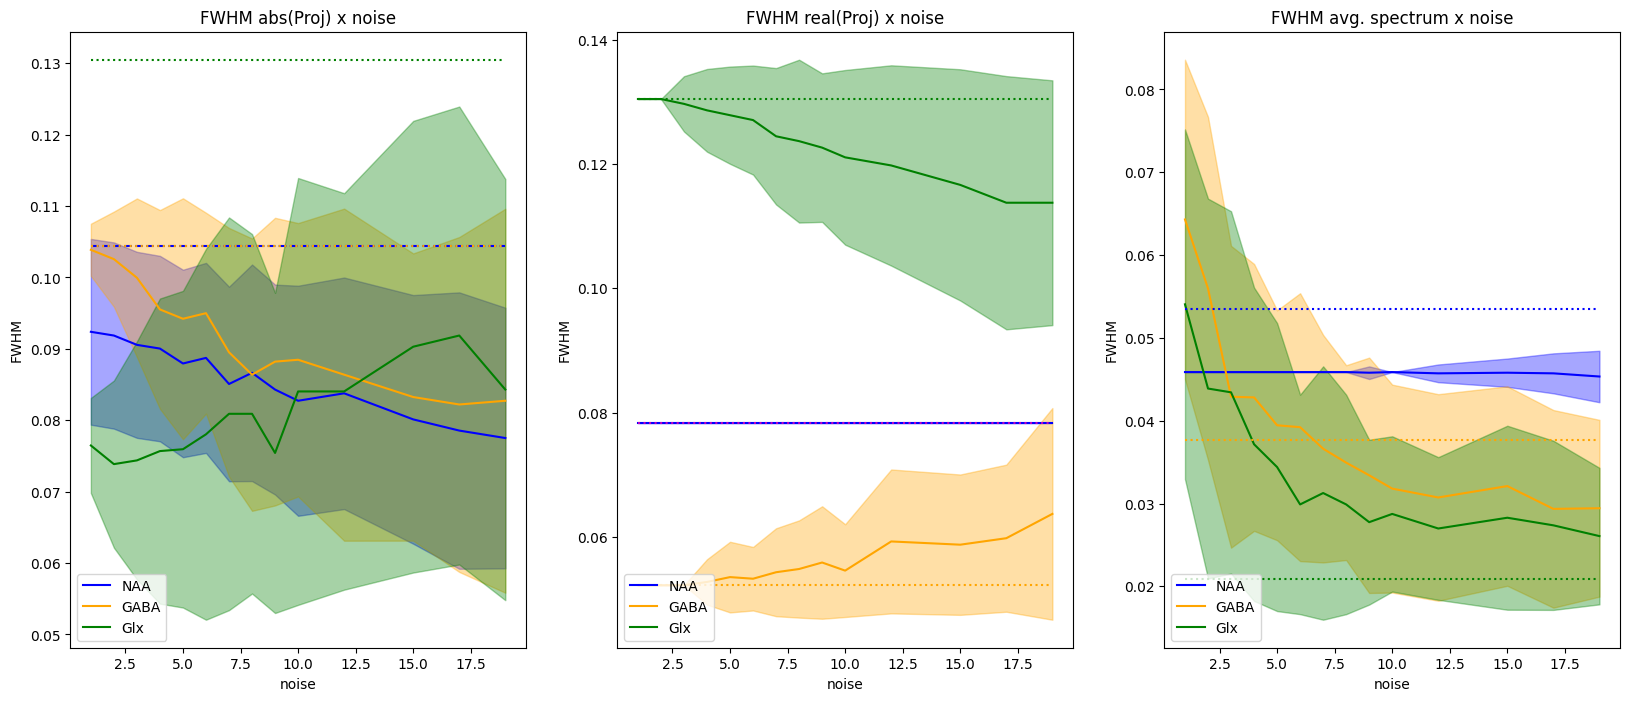

In [30]:
fig,ax = plt.subplots(1,3,figsize=(20,8))
seq_plot = [fwhm_ns,fwhm_ns_real,fwhm_spectrum]
name_plot = ['abs(Proj)','real(Proj)','avg. spectrum']
for j in range(3):
    ax.flat[j].plot(std_basis,seq_plot[j]['NAA']['mean'],label='NAA',color='b')
    ax.flat[j].fill_between(std_basis, np.array(seq_plot[j]['NAA']['mean']) - np.array(seq_plot[j]['NAA']['std']), 
                            np.array(seq_plot[j]['NAA']['mean']) + np.array(seq_plot[j]['NAA']['std']), alpha=0.35, color = 'b')
    ax.flat[j].plot(std_basis,seq_plot[j]['GABA']['mean'],label='GABA',color='orange')
    ax.flat[j].fill_between(std_basis, np.array(seq_plot[j]['GABA']['mean']) - np.array(seq_plot[j]['GABA']['std']), 
                            np.array(seq_plot[j]['GABA']['mean']) + np.array(seq_plot[j]['GABA']['std']), alpha=0.35, color = 'orange')
    ax.flat[j].plot(std_basis,seq_plot[j]['Glx']['mean'],label='Glx',color='g')
    ax.flat[j].fill_between(std_basis, np.array(seq_plot[j]['Glx']['mean']) - np.array(seq_plot[j]['Glx']['std']), 
                            np.array(seq_plot[j]['Glx']['mean']) + np.array(seq_plot[j]['Glx']['std']), alpha=0.35, color = 'g')
    ax.flat[j].set_title('FWHM '+name_plot[j]+' x noise')
    ax.flat[j].set_xlabel('noise')
    ax.flat[j].set_ylabel('FWHM')
    ax.flat[j].legend(loc='lower left')
ax.flat[0].hlines(fwhm_abs_spgram_gt['NAA']['mean'],1,19,color='b',linestyle='dashed')
ax.flat[0].hlines(fwhm_abs_spgram_gt['GABA']['mean'],1,19,color='orange',linestyle='dotted')
ax.flat[0].hlines(fwhm_abs_spgram_gt['Glx']['mean'],1,19,color='g',linestyle='dotted')
ax.flat[1].hlines(fwhm_real_spgram_gt['NAA']['mean'],1,19,color='m',linestyle='dotted')
ax.flat[1].hlines(fwhm_real_spgram_gt['GABA']['mean'],1,19,color='orange',linestyle='dotted')
ax.flat[1].hlines(fwhm_real_spgram_gt['Glx']['mean'],1,19,color='g',linestyle='dotted')
ax.flat[2].hlines(fwhm_spectrum_gt['NAA']['mean'],1,19,color='b',linestyle='dotted')
ax.flat[2].hlines(fwhm_spectrum_gt['GABA']['mean'],1,19,color='orange',linestyle='dotted')
ax.flat[2].hlines(fwhm_spectrum_gt['Glx']['mean'],1,19,color='g',linestyle='dotted')

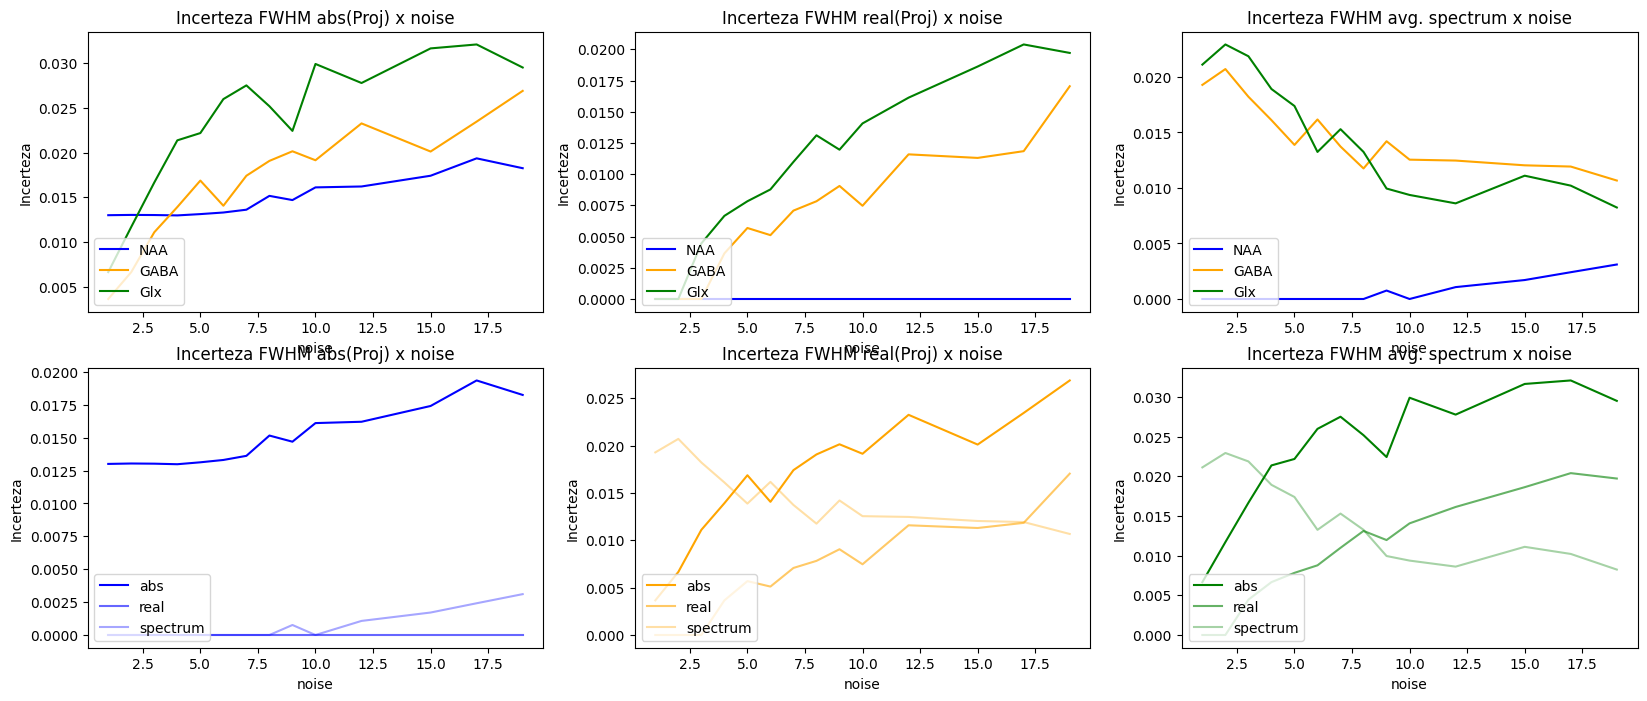

In [31]:
fig,ax = plt.subplots(2,3,figsize=(20,8))
seq_plot = [fwhm_ns,fwhm_ns_real,fwhm_spectrum]
name_plot = ['abs(Proj)','real(Proj)','avg. spectrum']
for j in range(3):
    ax.flat[j].plot(std_basis,seq_plot[j]['NAA']['std'],label='NAA',color='b')
    ax.flat[j].plot(std_basis,seq_plot[j]['GABA']['std'],label='GABA',color='orange')
    ax.flat[j].plot(std_basis,seq_plot[j]['Glx']['std'],label='Glx',color='g')
    ax.flat[j].set_title('Incerteza FWHM '+name_plot[j]+' x noise')
    ax.flat[j].set_xlabel('noise')
    ax.flat[j].set_ylabel('Incerteza')
    ax.flat[j].legend(loc='lower left')
name_ele = ['NAA','GABA','Glx']
colors = ['b','orange','g']
for j in range(3):
    ax.flat[j+3].plot(std_basis,fwhm_ns[name_ele[j]]['std'],label='abs',color=colors[j])
    ax.flat[j+3].plot(std_basis,fwhm_ns_real[name_ele[j]]['std'],label='real',color=colors[j],alpha=0.6)
    ax.flat[j+3].plot(std_basis,fwhm_spectrum[name_ele[j]]['std'],label='spectrum',color=colors[j],alpha=0.35)
    ax.flat[j+3].set_title('Incerteza FWHM '+name_plot[j]+' x noise')
    ax.flat[j+3].set_xlabel('noise')
    ax.flat[j+3].set_ylabel('Incerteza')
    ax.flat[j+3].legend(loc='lower left')

In [32]:
print('Aproximação linear da média do FWHM: abs(Proj)')
print('NAA: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_ns['NAA']['mean']), 1))
print('GABA: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_ns['GABA']['mean']), 1))
print('Glx: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_ns['Glx']['mean']), 1))
print('Aproximação linear da média do FWHM: real(Proj)')
print('NAA: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_ns_real['NAA']['mean']), 1))
print('GABA: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_ns_real['GABA']['mean']), 1))
print('Glx: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_ns_real['Glx']['mean']), 1))
print('Aproximação linear da média do FWHM: avg. spectrum')
print('NAA: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_spectrum['NAA']['mean']), 1))
print('GABA: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_spectrum['GABA']['mean']), 1))
print('Glx: ',np.polynomial.polynomial.polyfit(np.array(std_basis), np.array(fwhm_spectrum['Glx']['mean']), 1))

Aproximação linear da média do FWHM: abs(Proj)
NAA:  [ 0.09285605 -0.00084581]
GABA:  [ 0.10140652 -0.00119902]
Glx:  [0.07291352 0.00089216]
Aproximação linear da média do FWHM: real(Proj)
NAA:  [ 7.82895303e-02 -1.24234894e-18]
GABA:  [0.0504148  0.00060242]
Glx:  [ 0.13237696 -0.00104304]
Aproximação linear da média do FWHM: avg. spectrum
NAA:  [ 4.59677131e-02 -1.96871979e-05]
GABA:  [ 0.05124436 -0.00147766]
Glx:  [ 0.04336417 -0.00116861]


Espectrogramas concatenados:

In [28]:
aux_concat = (np.arange(0,len(std_basis),3)).tolist()
selected_keys = []
list_time_idx = []
for i in range(len(aux_concat)):
    selected_keys.append('noise_'+str(std_basis[aux_concat[i]]))
    list_time_idx.append(idx_time_0d4[aux_concat[i]])
spgram_ns_concat = utils.concatenate_generic(selected_keys=selected_keys,spgram_dict=spgram_ns,list_time_idx=list_time_idx,fid_idx_plot=0)

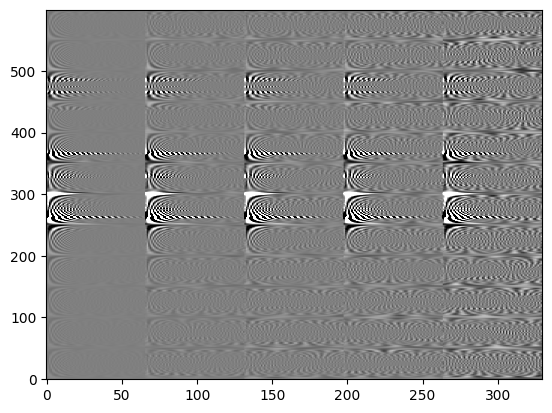

In [112]:
plt.imshow(np.real(spgram_ns_concat), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04)

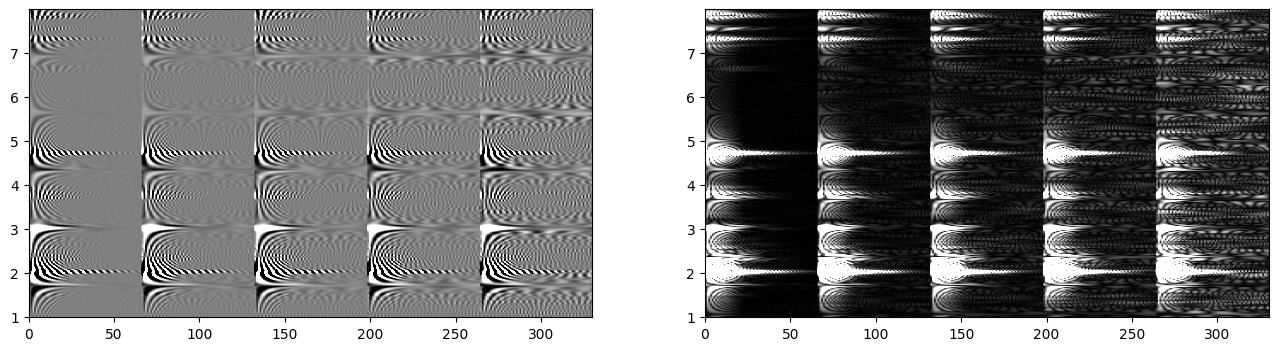

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(np.real(spgram_ns_concat[idx_freq_1ppm[0]:idx_freq_8ppm[0],:]), origin='lower', aspect='auto',cmap='gray',vmin=-0.04,vmax=0.04,
          extent = (0,spgram_ns_concat.shape[-1],np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[idx_freq_8ppm[0]]))
ax[1].imshow(np.abs(np.real(spgram_ns_concat[idx_freq_1ppm[0]:idx_freq_8ppm[0],:])), origin='lower', aspect='auto',cmap='gray',vmin=0,vmax=0.04,
          extent = (0,spgram_ns_concat.shape[-1],np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[idx_freq_1ppm[0]],np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[idx_freq_8ppm[0]]))

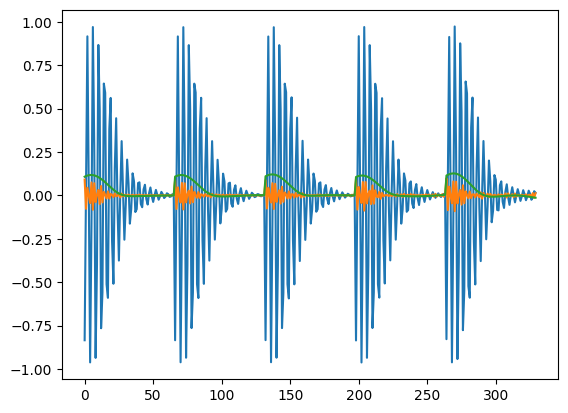

In [30]:
plt.plot(np.real(spgram_ns_concat[idx_freq_NAA[0],:]))
plt.plot(np.real(spgram_ns_concat[idx_freq_Glx[0],:]))
plt.plot(np.real(spgram_ns_concat[idx_freq_GABA[0],:]))

O padrão de listras não parece mudar com o ruído, porém, vamos obter o ZCR apenas como uma forma de testar a robustez da métrica com relação ao ruído:

In [31]:
zcr_ = paramstud.get_zcr_for_relevant_peaks_for_different_spgrams(spgram_dict=spgram_ns,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4)

Text(0.5, 0, 'ruído')

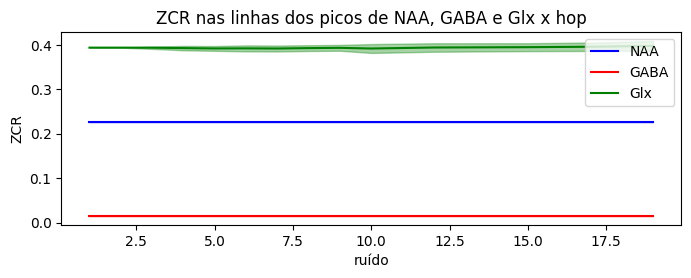

In [32]:
fig,ax = plt.subplots(1,1,figsize=(8,2.5))
ax.plot(std_basis,zcr_['NAA']['mean'],color='b',label='NAA')
ax.fill_between(std_basis, np.array(zcr_['NAA']['mean']) - np.array(zcr_['NAA']['std']), 
                        np.array(zcr_['NAA']['mean']) + np.array(zcr_['NAA']['std']), alpha=0.35, color = 'b')
ax.plot(std_basis,zcr_['GABA']['mean'],color='r',label='GABA')
ax.fill_between(std_basis, np.array(zcr_['GABA']['mean']) - np.array(zcr_['GABA']['std']), 
                        np.array(zcr_['GABA']['mean']) + np.array(zcr_['GABA']['std']), alpha=0.35, color = 'r')
ax.plot(std_basis,zcr_['Glx']['mean'],color='g',label='Glx')
ax.fill_between(std_basis, np.array(zcr_['Glx']['mean']) - np.array(zcr_['Glx']['std']), 
                        np.array(zcr_['Glx']['mean']) + np.array(zcr_['Glx']['std']), alpha=0.35, color = 'g')
ax.legend(loc='upper right')
plt.title('ZCR nas linhas dos picos de NAA, GABA e Glx x hop')
plt.ylabel('ZCR')
plt.xlabel('ruído')

Comprimento dos picos:

In [33]:
segm_dict = paramstud.segment_relevant_peaks_dict(spgram_dict=spgram_ns,idx_list_1ppm=idx_freq_1ppm,idx_list_4ppm=idx_freq_4ppm,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx,idx_time_list_0d4=idx_time_0d4,idx_peaks_regions_limits_dict=idx_fwhm_real)
sum_segment = paramstud.get_length_relevant_peaks_for_different_spgrams(segm_dict=segm_dict,spgram_dict=spgram_ns,idx_list_1ppm=idx_freq_1ppm,idx_list_4ppm=idx_freq_4ppm,idx_list_GABA=idx_freq_GABA,idx_list_NAA=idx_freq_NAA,idx_list_Glx=idx_freq_Glx)

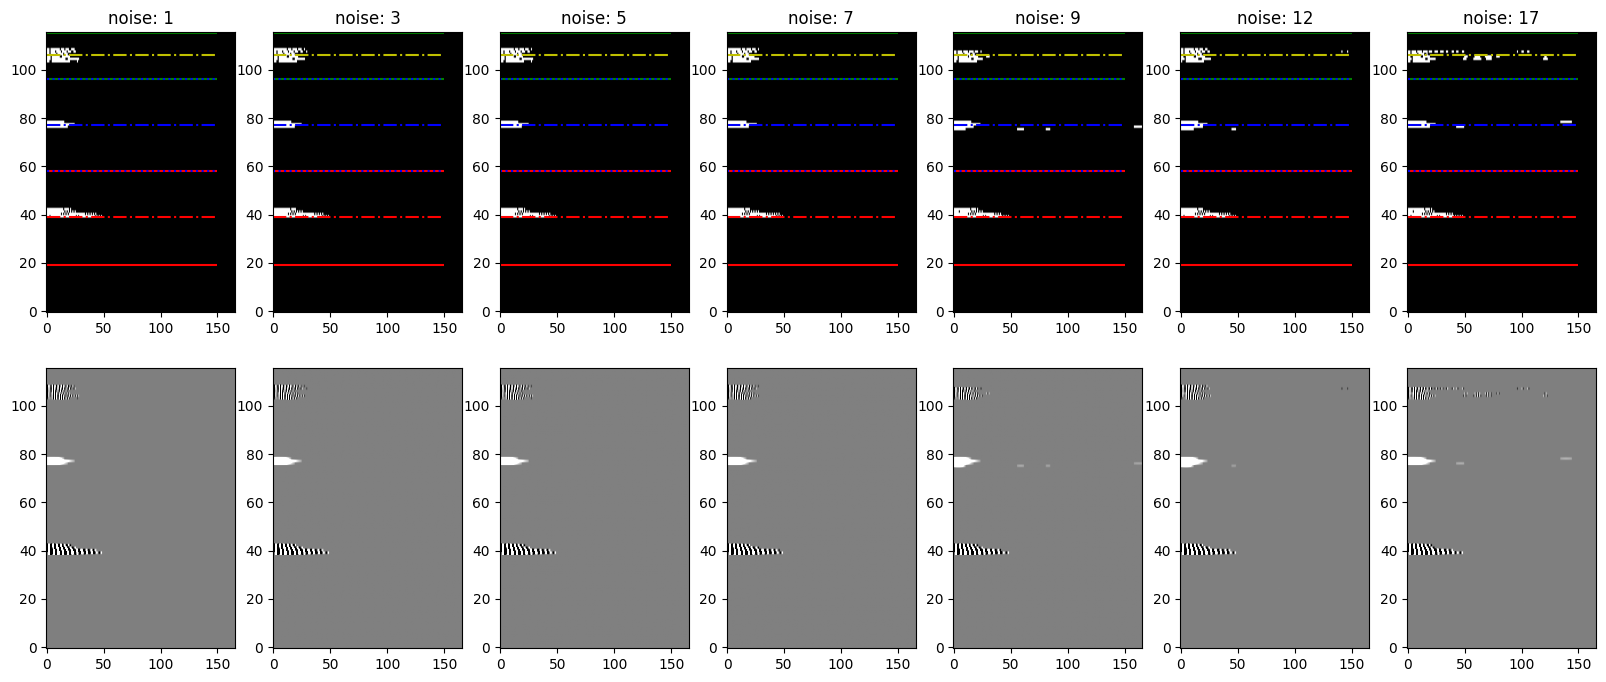

In [34]:
plot_id = np.arange(0,len(std_basis),2)
fig,ax = plt.subplots(2,7,figsize=(20,8))
for i in range(7):
    ax.flat[i].imshow(segm_dict['noise_'+str(std_basis[plot_id[i]])][0,:,:],cmap='gray',aspect='auto',origin='lower')
    ax.flat[i].set_title('noise: '+str(std_basis[plot_id[i]]))
    ax.flat[i+7].imshow(segm_dict['noise_'+str(std_basis[plot_id[i]])][0,:,:]*np.real(spgram_ns['noise_'+str(std_basis[plot_id[i]])][0][0,idx_freq_1ppm[plot_id[i]]:idx_freq_4ppm[plot_id[i]]+1,:]),cmap='gray',aspect='auto',origin='lower',vmin=-0.04,
                vmax=0.04)

for i in range(7):
    idx_NAA_plus1 = utils.give_idx_ppm_point(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2],2.50)
    idx_NAA_minus1 = utils.give_idx_ppm_point(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2],1.50)
    idx_GABA_plus1 = utils.give_idx_ppm_point(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2],3.50)
    idx_GABA_minus1 = utils.give_idx_ppm_point(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2],2.50)
    idx_Glx_plus1 = utils.give_idx_ppm_point(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2],4.00)
    idx_Glx_minus1 = utils.give_idx_ppm_point(spgram_ns['noise_'+str(std_basis[plot_id[i]])][2],3.50)
    ax.flat[i].hlines(idx_NAA_plus1-idx_freq_1ppm[plot_id[i]],0,150,color='r')
    ax.flat[i].hlines(idx_NAA_minus1-idx_freq_1ppm[plot_id[i]],0,150,color='r')
    ax.flat[i].hlines(idx_freq_NAA[plot_id[i]]-idx_freq_1ppm[plot_id[i]],0,150,color='r',linestyle='dashdot')
    ax.flat[i].hlines(idx_Glx_plus1-idx_freq_1ppm[plot_id[i]],0,150,color='g')
    ax.flat[i].hlines(idx_Glx_minus1-idx_freq_1ppm[plot_id[i]],0,150,color='g')
    ax.flat[i].hlines(idx_freq_Glx[plot_id[i]]-idx_freq_1ppm[plot_id[i]],0,150,color='y',linestyle='dashdot')
    ax.flat[i].hlines(idx_GABA_plus1-idx_freq_1ppm[plot_id[i]],0,150,color='b',linestyle='dotted')
    ax.flat[i].hlines(idx_GABA_minus1-idx_freq_1ppm[plot_id[i]],0,150,color='b',linestyle='dotted')
    ax.flat[i].hlines(idx_freq_GABA[plot_id[i]]-idx_freq_1ppm[plot_id[i]],0,150,color='b',linestyle='dashdot')

A partir de um determinado nível de ruído se torna difícil segmentar somente a região do pico:

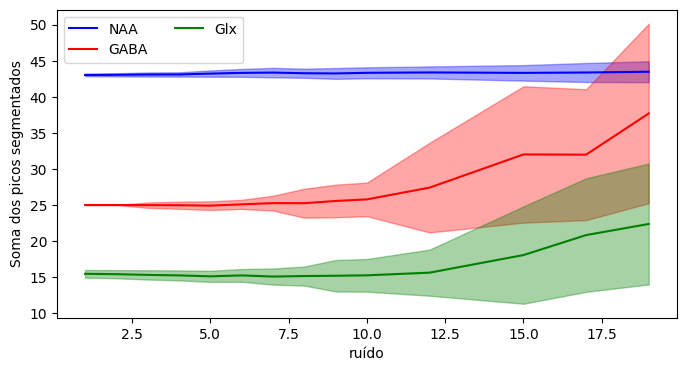

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
plt.plot(std_basis,sum_segment['NAA']['mean'],label='NAA',color='b')
plt.fill_between(std_basis, np.array(sum_segment['NAA']['mean']) - np.array(sum_segment['NAA']['std']), 
                        np.array(sum_segment['NAA']['mean']) + np.array(sum_segment['NAA']['std']), alpha=0.35, color = 'b')
plt.plot(std_basis,sum_segment['GABA']['mean'],label='GABA',color='r')
plt.fill_between(std_basis, np.array(sum_segment['GABA']['mean']) - np.array(sum_segment['GABA']['std']), 
                        np.array(sum_segment['GABA']['mean']) + np.array(sum_segment['GABA']['std']), alpha=0.35, color = 'r')
plt.plot(std_basis,sum_segment['Glx']['mean'],label='Glx',color='g')
plt.fill_between(std_basis, np.array(sum_segment['Glx']['mean']) - np.array(sum_segment['Glx']['std']), 
                        np.array(sum_segment['Glx']['mean']) + np.array(sum_segment['Glx']['std']), alpha=0.35, color = 'g')
plt.xlabel('ruído')
plt.ylabel('Soma dos picos segmentados')
plt.legend(loc='upper left',ncols=2)

Get some statistical insights:

First, let's divide the image in sections by defining masks based on GT spgrams:

In [36]:
seg_res = (np.abs(np.real(spgram_gt)) < 0.001).astype('int')
seg_res2 = (np.abs(np.real(spgram_gt)) > 0.001).astype('int')*(np.abs(np.real(spgram_gt)) < 0.02).astype('int')
seg_res3 = (np.abs(np.real(spgram_gt)) > 0.02).astype('int')*(np.abs(np.real(spgram_gt)) < 0.08).astype('int')
seg_res4 = (np.abs(np.real(spgram_gt)) > 0.08).astype('int')*(np.abs(np.real(spgram_gt)) < 0.2).astype('int')
seg_res5 = (np.abs(np.real(spgram_gt)) > 0.2).astype('int')*(np.abs(np.real(spgram_gt)) < 0.6).astype('int')
seg_res6 = (np.abs(np.real(spgram_gt)) > 0.6).astype('int')*(np.abs(np.real(spgram_gt[0,:,:])) < 1).astype('int')
masks = [seg_res,seg_res2,seg_res3,seg_res4,seg_res5,seg_res6]

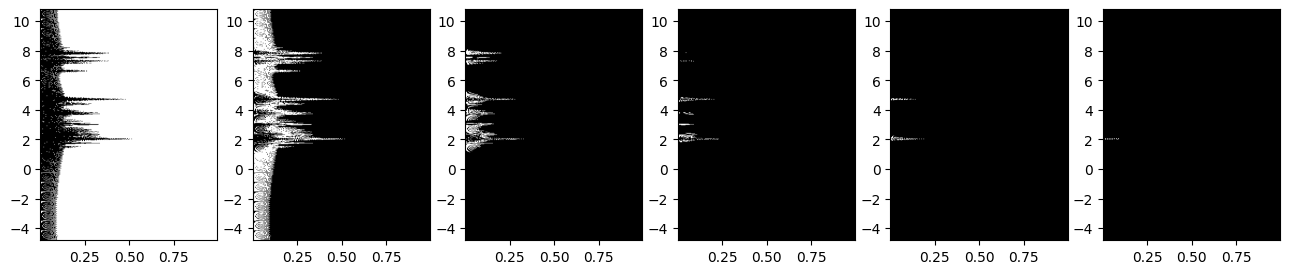

In [37]:
fig,ax = plt.subplots(1,6,figsize=(16,3))
for i in range(6):
    ax[i].imshow(masks[i][0,:,:],cmap='gray',origin='lower',aspect='auto',
            extent = (spgram_ns['noise_'+str(std_basis[0])][-1][0],spgram_ns['noise_'+str(std_basis[0])][-1][-1],
                    np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[0],np.flip(spgram_ns['noise_'+str(std_basis[0])][2])[-1]))

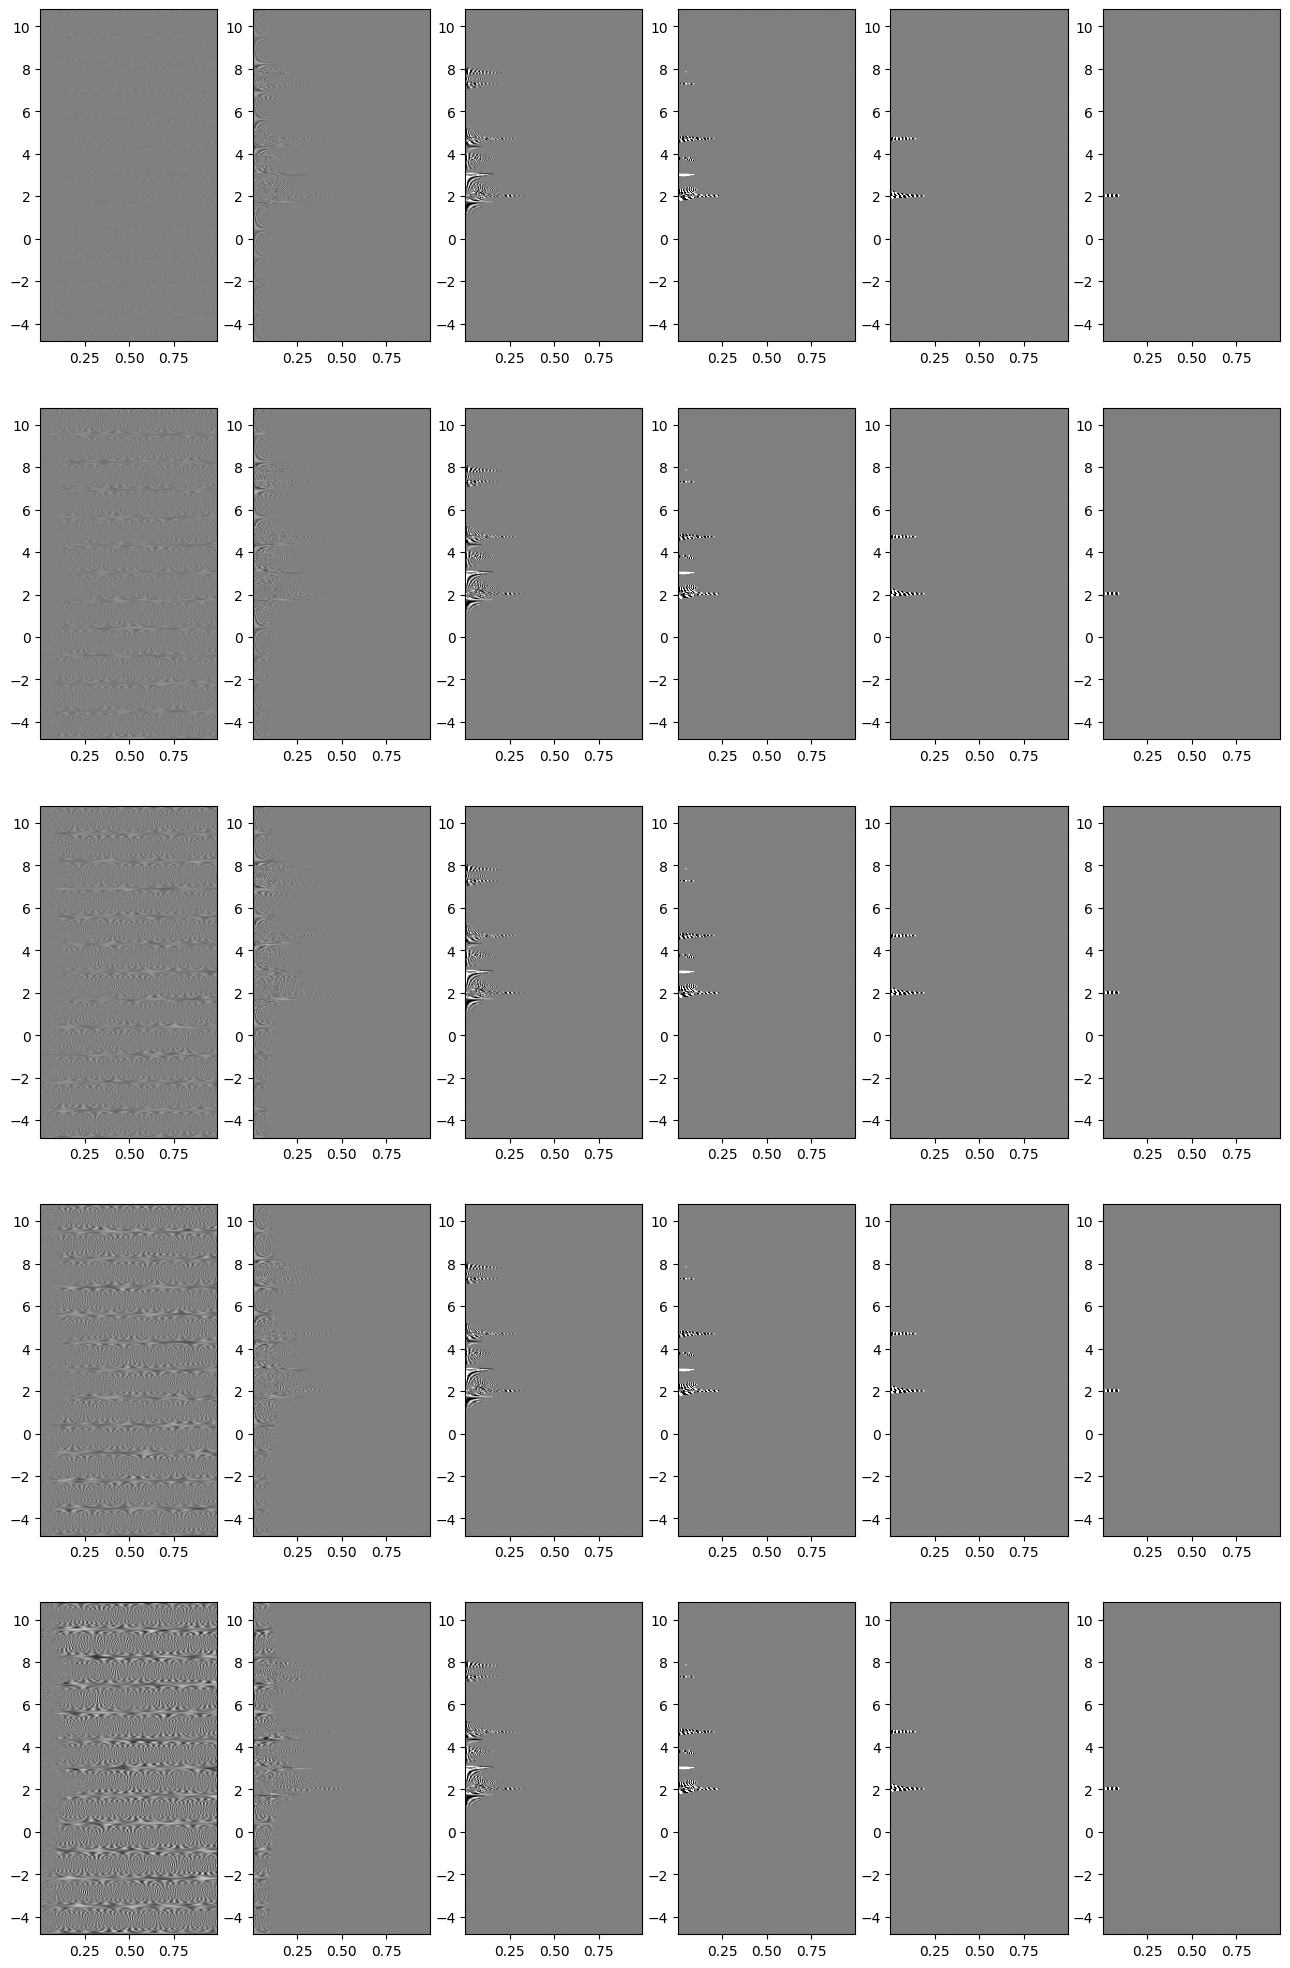

In [38]:
fig,ax = plt.subplots(5,6,figsize=(16,25))
plot_id = np.arange(0,len(std_basis),3)

for idx in range(len(plot_id)):
    for j in range(6):
        ax.flat[6*idx+j].imshow(np.real(spgram_ns['noise_'+str(std_basis[plot_id[idx]])][0][0,:,:])*masks[j][0,:,:],cmap='gray',origin='lower',aspect='auto',vmin=-0.04,vmax=0.04,
                    extent = (spgram_ns['noise_'+str(std_basis[plot_id[idx]])][-1][0],spgram_ns['noise_'+str(std_basis[plot_id[idx]])][-1][-1],
                    np.flip(spgram_ns['noise_'+str(std_basis[plot_id[idx]])][2])[0],np.flip(spgram_ns['noise_'+str(std_basis[plot_id[idx]])][2])[-1]))

Stats of each masked region x noise:

In [39]:
stats_per_region = noisestud.stats_per_masked_regions_for_different_spgrams(masks=masks,spgram_dict=spgram_ns, part='real')

In [40]:
stats_global = utils.stats_global_for_different_spgrams(spgram_dict=spgram_ns, part='part')

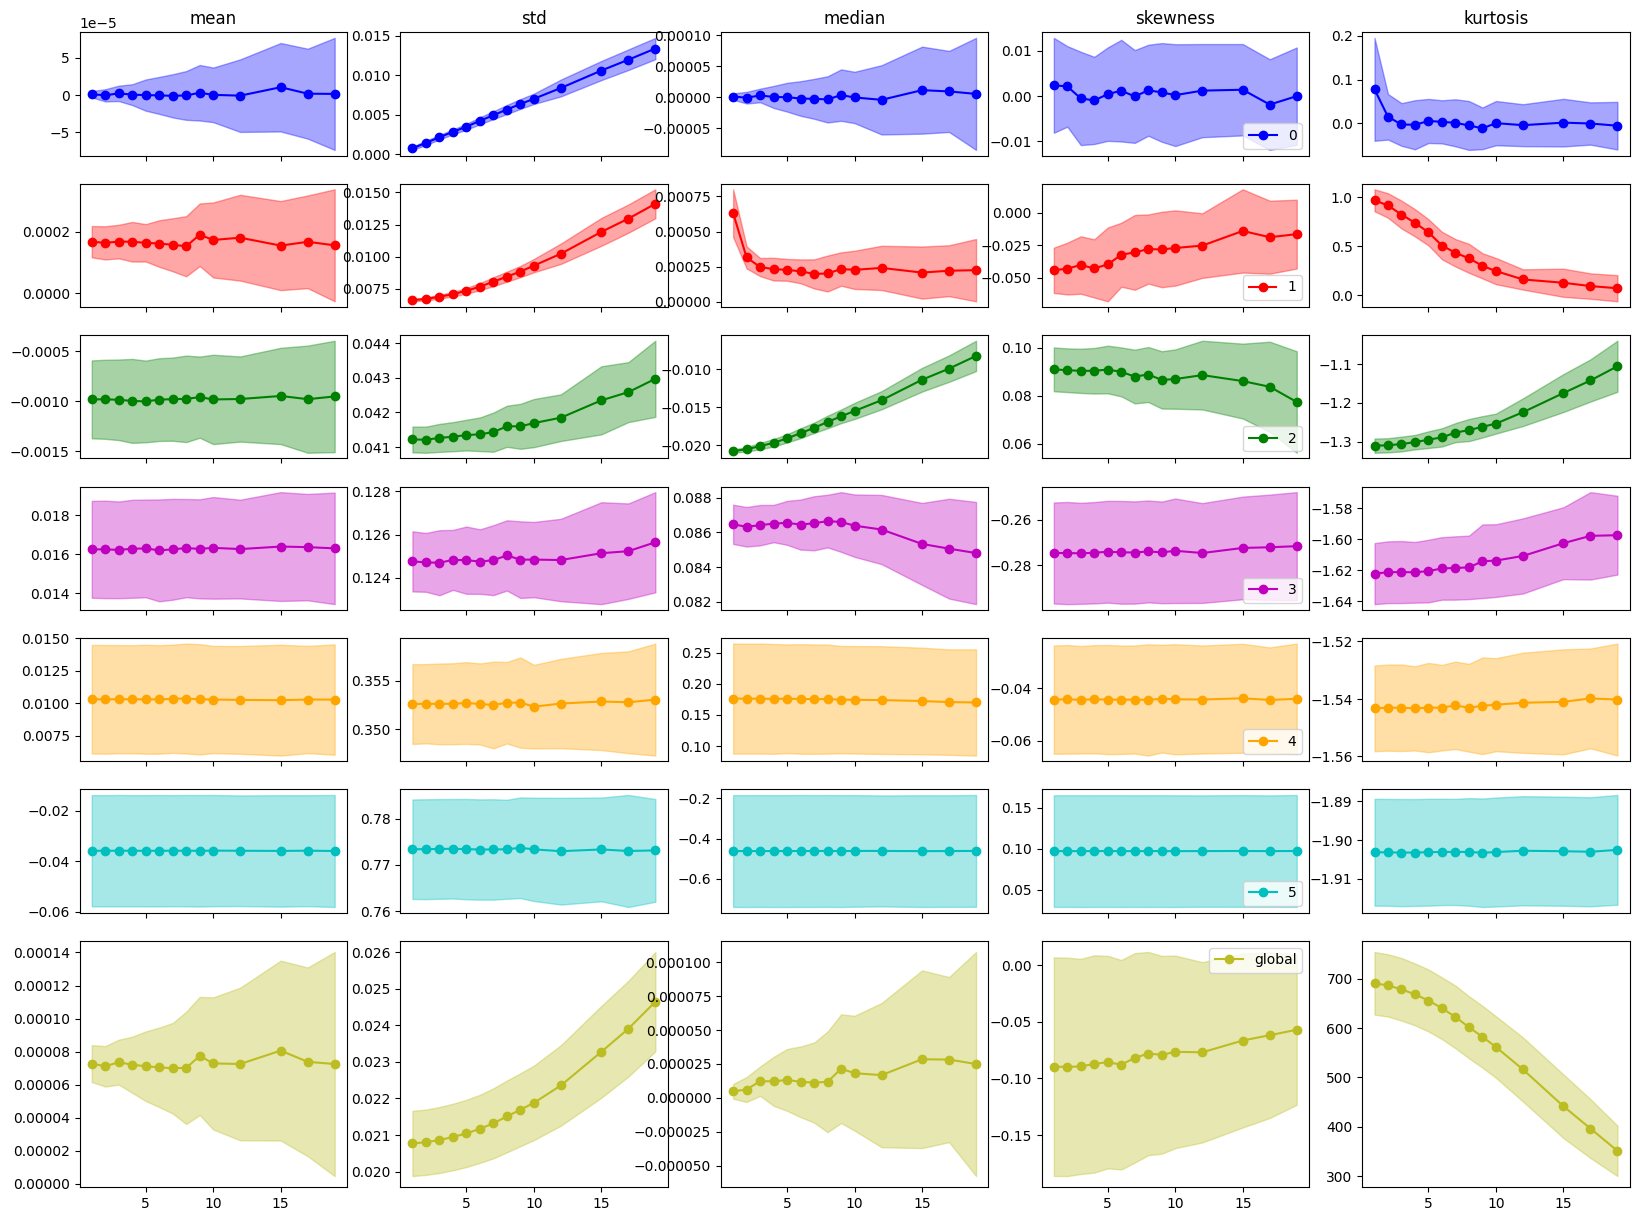

In [41]:
fig,ax = plt.subplots(7,5,figsize=(20,15), sharex='col', height_ratios=[1, 1, 1, 1, 1, 1, 2])

stat_name = ['mean','std','median','skewness','kurtosis']
colors = ['b','r','g','m','orange','c']
for j in range(len(stat_name)):
    for i in range(len(list(stats_per_region[stat_name[j]].keys()))):
        aux = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['mean'])
        aux_std = np.array(stats_per_region[stat_name[j]][list(stats_per_region[stat_name[j]].keys())[i]]['std'])
        ax[i,j].plot(std_basis,aux,marker='o',color=colors[i],label=list(stats_per_region[stat_name[j]].keys())[i])
        ax[i,j].fill_between(std_basis, aux - aux_std, 
                           aux + aux_std, alpha=0.35, color = colors[i])
        if i == 0:
            ax[i,j].set_title(stat_name[j])
        if j == 3:
            ax[i,j].legend(loc='lower right')
colors = ['#bcbd22']
for i in range(len(stat_name)):
    aux = np.array(stats_global[stat_name[i]]['mean'])
    aux_std = np.array(stats_global[stat_name[i]]['std'])
    ax[6,i].plot(std_basis,aux,marker='o',color=colors[0],label="global")
    ax[6,i].fill_between(std_basis, aux - aux_std, 
                       aux + aux_std, alpha=0.35, color = colors[0])
    if i == 3:
        ax[6,i].legend(loc='upper right')
plt.show()

Checking visually the metrics obtained:

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(20,8))
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
plot_id = np.arange(0,38,6)
for i in (range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.001
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0,0].hist(aux,500,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[1,0].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[0,0].set_xlim(-0.00005,0.0001)
    ax[0,0].legend(loc='upper left')

axins_0 = ax[0,0].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0, 0.0001), ylim=(0, 2000))
ax[0,0].indicate_inset_zoom(axins_0, edgecolor="black")


axins = ax[1,0].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0001, 0.001), ylim=(0, 200))
ax[1,0].indicate_inset_zoom(axins, edgecolor="black")
axins2 = ax[1,0].inset_axes([0.01, 0.2, 0.4, 0.7], 
                              xlim=(-0.001, -0.0001), ylim=(0, 200),
                               xticklabels=[], yticklabels=[])
ax[1,0].indicate_inset_zoom(axins2, edgecolor="black")
for i in (range(len(plot_id))):
        seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0])) < 0.001
        aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0]).ravel()
        axins_0.hist(aux, bins=500, alpha=0.5,density=True,color=colors[i])
        axins.hist(aux, bins=200, alpha=0.5,density=True,color=colors[i])
        axins2.hist(aux, bins=200,alpha=0.5,density=True,color=colors[i])

plot_id = np.arange(38,45,2)
for i in reversed(range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.001
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0,1].hist(aux,500,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[1,1].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[0,1].set_xlim(-0.00005,0.0001)
    ax[0,1].legend(loc='upper left')

axins_5 = ax[0,1].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0, 0.0001), ylim=(0, 2000))
ax[0,1].indicate_inset_zoom(axins_5, edgecolor="black")

axins3 = ax[1,1].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0001, 0.001), ylim=(0, 200))
ax[1,1].indicate_inset_zoom(axins3, edgecolor="black")
axins4 = ax[1,1].inset_axes([0.01, 0.2, 0.4, 0.7], 
                              xlim=(-0.001, -0.0001), ylim=(0, 200),
                            xticklabels=[], yticklabels=[])
ax[1,1].indicate_inset_zoom(axins4, edgecolor="black")
for i in reversed(range(len(plot_id))):
        seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0])) < 0.001
        aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0]).ravel()
        axins_5.hist(aux, bins=500, alpha=0.5,density=True,color=colors[i])
        axins3.hist(aux, bins=200, alpha=0.5,density=True,color=colors[i])
        axins4.hist(aux, bins=200,alpha=0.5,density=True,color=colors[i])

plot_id = np.arange(45,len(hop_),3)
for i in (range(len(plot_id))):
    seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.001
    aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    ax[0,2].hist(aux,500,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[1,2].hist(aux,200,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]),color=colors[i])
    ax[0,2].set_xlim(-0.00005,0.0001)
    ax[0,2].legend(loc='upper left')

axins_6 = ax[0,2].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0, 0.0001), ylim=(0, 2000))
ax[0,2].indicate_inset_zoom(axins_6, edgecolor="black")

axins7 = ax[1,2].inset_axes([0.6, 0.2, 0.4, 0.7], 
                              xlim=(0.0001, 0.001), ylim=(0, 200))
ax[1,2].indicate_inset_zoom(axins7, edgecolor="black")
axins8 = ax[1,2].inset_axes([0.01, 0.2, 0.4, 0.7], 
                              xlim=(-0.001, -0.0001), ylim=(0, 200),
                            xticklabels=[], yticklabels=[])
ax[1,2].indicate_inset_zoom(axins8, edgecolor="black")
for i in (range(len(plot_id))):
        seg_ = np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0])) < 0.001
        aux = np.real(seg_*spgram_hop['hop_'+str(hop_[plot_id[i]])][0]).ravel()
        axins_6.hist(aux, bins=500, alpha=0.5,density=True,color=colors[i])
        axins7.hist(aux, bins=200, alpha=0.5,density=True,color=colors[i])
        axins8.hist(aux, bins=200,alpha=0.5,density=True,color=colors[i])

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(20,6))
plot_id = np.arange(1,len(hop_),15)
for i in (range(len(plot_id))):
    seg_2 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.001).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.02).astype('int')
    aux = np.real(seg_2*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[0].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[1].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_4 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.08).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.2).astype('int')
    aux = np.real(seg_4*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[2].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    seg_5 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.2).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.6).astype('int')
    aux = np.real(seg_5*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[3].hist(aux_no_zeros,50,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    

plot_id = np.arange(1,len(hop_),9)
for i in (range(len(plot_id))):
    seg_6 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.6).astype('int')
    aux = np.real(seg_6*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    ax.flat[4].hist(aux_no_zeros,15,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))
    ax.flat[5].scatter(np.arange(aux_no_zeros.shape[0]),aux_no_zeros,marker='o')

ax.flat[0].legend(loc='upper right')
ax.flat[4].legend(loc='upper center')

In [ ]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (kurt/std) for region ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_per_region['kurtosis'][reg]['mean']))

In [ ]:
from scipy import stats
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (skew/mean) for region ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_per_region['skewness'][reg]['mean']))

In [ ]:
plot_id = np.arange(len(hop_))
for i in (range(len(plot_id))):
    seg_3 = (np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) > 0.02).astype('int')*(np.abs(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:])) < 0.08).astype('int')
    aux = np.real(seg_3*spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel()
    aux_no_zeros = aux[aux != 0]
    hist_aux,bins_aux = np.histogram(aux_no_zeros,50,density = True)
    idx = []
    for k in range(len(hist_aux)):
        if hist_aux[k] == 0:
            idx.append(k)
    print(np.sum(hist_aux[:idx[0]]),np.sum(hist_aux[idx[-1]+1:]))

In [ ]:
plot_id = np.arange(2,len(hop_),8)
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

fig,ax = plt.subplots(1,1,figsize=(16,4))
for i in reversed(range(len(plot_id))):
    plt.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(),1000,alpha=0.5,density = True,label = 'hop_'+str(hop_[plot_id[i]]))



axins = ax.inset_axes([0.1, 0.7, 0.3, 0.3], xlim=(-1, -0.1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins, edgecolor="black")

# Create the second inset (-0.1, -0.001)
axins2 = ax.inset_axes([0.1, 0.3, 0.3, 0.3], xlim=(-0.1, -0.001), ylim=(0, 7))
ax.indicate_inset_zoom(axins2, edgecolor="black")

# Create the third inset (0.001, 0.1)
axins3 = ax.inset_axes([0.6, 0.3, 0.3, 0.3], xlim=(0.001, 0.1), ylim=(0, 7))
ax.indicate_inset_zoom(axins3, edgecolor="black")

# Create the fourth inset (0.1, 1)
axins4 = ax.inset_axes([0.6, 0.7, 0.3, 0.3], xlim=(0.1, 1), ylim=(0, 0.08))
ax.indicate_inset_zoom(axins4, edgecolor="black")


for i in (range(len(plot_id))):
        axins.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins2.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200,alpha=0.5,density=True,color=colors[i])
        axins3.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
        axins4.hist(np.real(spgram_hop['hop_'+str(hop_[plot_id[i]])][0][0,:,:]).ravel(), bins=200, alpha=0.5,density=True,color=colors[i])
plt.legend(loc='lower left', ncols=3)

In [ ]:
print('mean')
for reg in list(stats_per_region['mean'].keys()):
    print("test hypothesis (mean) global and ",reg,":",stats.pearsonr(stats_per_region['mean'][reg]['mean'], stats_global['mean']['mean']))
print('std')
for reg in list(stats_per_region['std'].keys()):
    print("test hypothesis (std) global and ",reg,":",stats.pearsonr(stats_per_region['std'][reg]['mean'], stats_global['std']['mean']))

In [ ]:
stats.pearsonr(stats_global['std']['mean'], stats_global['kurtosis']['mean'])

In [ ]:
stats.pearsonr(stats_global['mean']['mean'], stats_global['skewness']['mean'])

In [ ]:
if test_not_save == False:
    zcr_list = {}
    zcr_list['NAA'] = {}
    zcr_list['NAA']['mean'] = list(zcr_['NAA']['mean'])
    zcr_list['NAA']['std'] = list(zcr_['NAA']['std'])
    zcr_list['GABA'] = {}
    zcr_list['GABA']['mean'] = list(zcr_['GABA']['mean'])
    zcr_list['GABA']['std'] = list(zcr_['GABA']['std'])
    zcr_list['Glx'] = {}
    zcr_list['Glx']['mean'] = list(zcr_['Glx']['mean'])
    zcr_list['Glx']['std'] = list(zcr_['Glx']['std'])
    with open("quantitative_metrics_no_noise_hop_variation_mfft_512.txt", "w") as f:
        f.write("fwhm_hop=")
        f.write(json.dumps(fwhm_hop))
        f.write('\n')
        f.write("fwhm_hop_real=")
        f.write(json.dumps(fwhm_hop_real))
        f.write('\n')
        f.write("zcr_=")
        f.write(json.dumps(zcr_list))
        f.write('\n')
        f.write("max_sec=")
        f.write(json.dumps(max_sec))
        f.write('\n')
        f.write("qntty_percent_regions=")
        f.write(json.dumps(qntty_percent_regions))
        f.write('\n')
        f.write("qntty_absolute_regions=")
        f.write(json.dumps(qntty_absolute_regions))
        f.write('\n')
        f.write("stats_per_region=")
        f.write(json.dumps(stats_per_region))
        f.write('\n')
        f.write("stats_global=")
        f.write(json.dumps(stats_global))